# Analysing and Comparing Braille Datasets

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats


import PIL
from PIL import ImageDraw, ImageFont

import json

import torch
import torch.nn.functional as F

import time
from tqdm import tqdm

from model_utils import ModelWrapper, myDataLoader
from model_utils.braille_utils import num_to_bin_string, bin_to_num, num_to_bin, ml_to_mc, mc_to_ml, bin_to_string, string_to_bin
from model_utils.metrics import sigmoid_accuracy, bitwise_accuracy, bitwise_recall, bitwise_precision, bitwise_F1,\
    macro_metrics, macro_recall, macro_precision, macro_F1, hamming_distances, mean_hamming_distance, mean_error_distance, \
    per_class_precision, per_class_recall, per_class_F1
from model_utils.augment import label_balance_resample, class_balance_resample, adaptive_resample, apply_augmentations
from model_utils.metrics import class_balance, label_correlations, label_correlations_v2, class_frequency, between_label_imbalance, mean_mutual_information

c:\Users\User\OneDrive\Uni\Braille Research\Braille ML\venv\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
np.__version__


'1.26.4'

### Figure fonts and styling

In [4]:
from matplotlib.patches import Patch, PathPatch, Rectangle, Shadow, Ellipse
from matplotlib.lines import Line2D
from matplotlib import text as mtext
import matplotlib.transforms as transforms
import matplotlib.ticker as ticker
from matplotlib import legend as mlegend
from matplotlib import colors as mpl_colors

In [5]:
sns_style1 = "darkgrid"
sns_style2 = "dark"
sns.set_theme(style=sns_style1, font_scale=1.1)

In [6]:
plt_face = sns.axes_style()['figure.facecolor']
ax_face = sns.axes_style()['axes.facecolor']

In [7]:

PAL = sns.color_palette()
DARK_PAL = sns.color_palette('dark')
plt.rcParams["font.family"] = "Times New Roman" # or "Arial"
LBL_LARGE = 20
LBL_SIZE = 18
TICK_SIZE = 16
TINY = 12

In [8]:

DATASETS = os.path.join('..', '..', 'Datasets', 'numpy_datasets')
MODEL_PATH = os.path.join('..', 'models')
PLOTS = os.path.join('..', 'plots')
PLOT_DATA = os.path.join(PLOTS, 'data')
EVAL = os.path.join('..', 'evals')
ML_LOGS = os.path.join('..', 'opt_logs', 'ml_tuning')
MC_LOGS = os.path.join('..', 'opt_logs', 'mc_tuning')

PAL

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

### Color Palettes

In [9]:
BLUE = "#1f77b4"
ORANGE = "#ffa35c"
RED = "#e50c3f"
# YELLOW = "#f1c232"
YELLOW = "#FFF55C"
DARK = "#0c343d"
LIGHT = "#efeae6"
GREEN = "#00a060"

BLACK = "#000000"
GREY = "#8F8F8F"
WHITE = "#ffffff"

In [10]:
# CPAL = sns.color_palette([
#     RED,
#     ORANGE,
#     BLUE,
#     GREEN,
#     YELLOW,
#     LIGHT,
#     GREY,
#     DARK
# ])

CPAL = sns.color_palette([
    PAL[3],
    PAL[1],
    PAL[0],
    PAL[2],
    PAL[7],
    PAL[5]
])

BLUE = CPAL[2]
ORANGE = CPAL[1]
RED = CPAL[0]
GREEN = CPAL[3]

SPAL = sns.color_palette([
    PAL[4],
    PAL[8],
    PAL[5],
    PAL[6],
    PAL[9],
    PAL[7]
])

TPAL = sns.color_palette([
    DARK_PAL[4],
    DARK_PAL[8],
    DARK_PAL[5],
    DARK_PAL[6],
    DARK_PAL[9],
    DARK_PAL[3],
    DARK_PAL[1],
    DARK_PAL[0],
    DARK_PAL[2],
    DARK_PAL[7],
])

display(CPAL)
display(SPAL)
display(TPAL)

[(0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941)]

[(0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373)]

[(0.34901960784313724, 0.11764705882352941, 0.44313725490196076),
 (0.7215686274509804, 0.5215686274509804, 0.0392156862745098),
 (0.34901960784313724, 0.1843137254901961, 0.050980392156862744),
 (0.6352941176470588, 0.20784313725490197, 0.5098039215686274),
 (0.0, 0.38823529411764707, 0.4549019607843137),
 (0.5490196078431373, 0.03137254901960784, 0.0),
 (0.6941176470588235, 0.25098039215686274, 0.050980392156862744),
 (0.0, 0.10980392156862745, 0.4980392156862745),
 (0.07058823529411765, 0.44313725490196076, 0.10980392156862745),
 (0.23529411764705882, 0.23529411764705882, 0.23529411764705882)]

In [11]:
RGB_NUM = 7

RPAL = sns.blend_palette([
    LIGHT,
    CPAL[0],
    DARK
], n_colors=RGB_NUM)

OPAL = sns.blend_palette([
    LIGHT,
    CPAL[1],
    CPAL[0]
], n_colors=RGB_NUM)

BPAL = sns.blend_palette([
    LIGHT,
    CPAL[2],
    DARK
], n_colors=RGB_NUM)

GPAL = sns.blend_palette([
    LIGHT,
    CPAL[3],
    DARK
], n_colors=RGB_NUM)

BWPAL = sns.blend_palette([
    BLACK,
    WHITE
], n_colors=RGB_NUM*2)

PALS = [
    RPAL,
    OPAL,
    BPAL,
    GPAL
]

display(RPAL)
display(OPAL)
display(BPAL)
display(GPAL)
display(BWPAL)

[(0.9372549019607843, 0.9176470588235294, 0.9019607843137255),
 (0.8817070357554787, 0.7161245674740484, 0.7107727797001153),
 (0.8248366013071896, 0.5098039215686274, 0.5150326797385621),
 (0.7657977700884275, 0.3054825067281815, 0.32124567474048443),
 (0.5281045751633987, 0.27189542483660134, 0.29411764705882354),
 (0.2847520184544406, 0.23750865051903114, 0.26634371395617074),
 (0.047058823529411764, 0.20392156862745098, 0.23921568627450981)]

[(0.9372549019607843, 0.9176470588235294, 0.9019607843137255),
 (0.914002306805075, 0.7858823529411765, 0.7107727797001153),
 (0.8901960784313726, 0.6509803921568628, 0.5150326797385621),
 (0.8662821991541715, 0.5168166089965398, 0.3215686274509804),
 (0.8339869281045752, 0.44705882352941184, 0.3215686274509804),
 (0.8009227220299885, 0.37564013840830457, 0.3215686274509804),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)]

[(0.9372549019607843, 0.9176470588235294, 0.9019607843137255),
 (0.7266897347174164, 0.762629757785467, 0.8322029988465974),
 (0.5111111111111112, 0.603921568627451, 0.7607843137254902),
 (0.29705497885428683, 0.44610534409842373, 0.6884275278738946),
 (0.21437908496732028, 0.36601307189542487, 0.5398692810457517),
 (0.12973471741637832, 0.28401384083044984, 0.38777393310265285),
 (0.047058823529411764, 0.20392156862745098, 0.23921568627450981)]

[(0.9372549019607843, 0.9176470588235294, 0.9019607843137255),
 (0.7383160322952711, 0.8323875432525951, 0.73919261822376),
 (0.534640522875817, 0.7450980392156863, 0.5725490196078431),
 (0.33221068819684735, 0.657039600153787, 0.4071818531334102),
 (0.23790849673202613, 0.5071895424836601, 0.35163398692810455),
 (0.141361014994233, 0.35377162629757786, 0.29476355247981545),
 (0.047058823529411764, 0.20392156862745098, 0.23921568627450981)]

[(0.0, 0.0, 0.0),
 (0.07450980392156863, 0.07450980392156863, 0.07450980392156863),
 (0.15294117647058825, 0.15294117647058825, 0.15294117647058825),
 (0.23137254901960785, 0.23137254901960785, 0.23137254901960785),
 (0.3058823529411765, 0.3058823529411765, 0.3058823529411765),
 (0.38431372549019605, 0.38431372549019605, 0.38431372549019605),
 (0.4627450980392157, 0.4627450980392157, 0.4627450980392157),
 (0.5372549019607843, 0.5372549019607843, 0.5372549019607843),
 (0.615686274509804, 0.615686274509804, 0.615686274509804),
 (0.6941176470588235, 0.6941176470588235, 0.6941176470588235),
 (0.7686274509803921, 0.7686274509803921, 0.7686274509803921),
 (0.8470588235294118, 0.8470588235294118, 0.8470588235294118),
 (0.9254901960784314, 0.9254901960784314, 0.9254901960784314),
 (1.0, 1.0, 1.0)]

In [12]:
CONPAL = sns.blend_palette([
    RED,
    BLUE,
    DARK,
    BLUE,
    ORANGE
], n_colors=20)
CONPAL

[(0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.6726643598615918, 0.33467128027681664, 0.39673971549404075),
 (0.5767012687427913, 0.3634602076124568, 0.47191080353710113),
 (0.4733564013840831, 0.39446366782006925, 0.5528642829680892),
 (0.3773933102652826, 0.42325259515570934, 0.6280353710111495),
 (0.28524413687043443, 0.4346635909265667, 0.66720492118416),
 (0.2340638216070742, 0.38508266051518647, 0.5752402921953095),
 (0.17894655901576317, 0.3316878123798539, 0.4762014609765475),
 (0.12776624375240292, 0.28210688196847367, 0.38423683198769704),
 (0.07264898116109189, 0.2287120338331411, 0.28519800076893503),
 (0.07264898116109189, 0.2287120338331411, 0.28519800076893503),
 (0.1277662437524028, 0.28210688196847356, 0.38423683198769687),
 (0.17894655901576317, 0.3316878123798539, 0.4762014609765475),
 (0.2340638216070742, 0.38508266051518647, 0.5752402921953095),
 (0.28524413687043443, 0.4346635909265667, 0.6672049211841599),
 (0.3939254133025759, 0.458961937716263, 0.6280353710111496),
 (0.5098808150711265, 0.4733564013840831, 0.5528642829680892),
 (0.6347558631295656, 0.4888581314878893, 0.47191080353710113),
 (0.750711264898116, 0.5032525951557094, 0.3967397154940408),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804)]

In [13]:
DIVPAL = sns.blend_palette([
    RED,
    LIGHT,
    YELLOW
], n_colors=20)
DIVPAL

[(0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.7858208381391772, 0.3682583621683968, 0.3807458669742407),
 (0.8030142252979624, 0.4306343713956171, 0.439923106497501),
 (0.8215301806997309, 0.49780853517877743, 0.5036524413687044),
 (0.838723567858516, 0.5601845444059976, 0.5628296808919646),
 (0.8572395232602845, 0.6273587081891581, 0.626559015763168),
 (0.8744329104190696, 0.6897347174163784, 0.6857362552864283),
 (0.8929488658208382, 0.7569088811995386, 0.7494655901576317),
 (0.9101422529796233, 0.8192848904267589, 0.808642829680892),
 (0.9286582083813918, 0.8864590542099192, 0.8723721645520952),
 (0.9404536716647444, 0.9198462129950019, 0.8743713956170703),
 (0.9473433294886582, 0.9245828527489427, 0.8149480968858133),
 (0.9537408688965783, 0.9289811610918877, 0.7597693194925028),
 (0.9606305267204921, 0.9337178008458286, 0.7003460207612456),
 (0.9670280661284122, 0.9381161091887735, 0.6451672433679354),
 (0.973917723952326, 0.9428527489427143, 0.5857439446366781),
 (0.9803152633602461, 0.9472510572856594, 0.5305651672433679),
 (0.9872049211841599, 0.9519876970396002, 0.4711418685121107),
 (0.99360246059208, 0.9563860053825451, 0.41596309111880037),
 (1.0, 0.9607843137254902, 0.3607843137254902)]

## Document to Character Process

In [11]:
angelina_doc = os.path.join('..', '..', 'Datasets', 'braille_angelina', 'train')
demo_sample = 'Angelina Dataset_cdr_0'

In [18]:
def index_to_decimal(ix_list: list):
    dec = 0
    for idx in ix_list:
        dec += 2 ** int(idx)
    return dec

In [65]:
page_file = os.path.join(angelina_doc, 'images', f'{demo_sample}.png')
page = cv2.imread(page_file)

labels_df = pd.DataFrame(columns=['Label', 'X', 'Y', 'W', 'H'])
with open(os.path.join(angelina_doc, 'labels', f'{demo_sample}.txt'), 'r') as temp_file:
    for line in temp_file.readlines():
        labels_df.loc[len(labels_df)] = [float(l) for l in line.split(" ")]
labels_df = labels_df.groupby(["X", "Y", "W", "H"])['Label'].apply(index_to_decimal).reset_index()

In [62]:
subset_labels = labels_df[(labels_df.Y < 0.21) &
                          (labels_df.X < 0.66)]
subset_labels.shape

(21, 5)

In [69]:
subset_labels.head()

,X,Y,W,H,Label
20,0.291756,0.164270,0.031009,0.034481,31
21,0.292207,0.077489,0.031291,0.035310,5
27,0.327369,0.076648,0.031291,0.035310,50
28,0.327504,0.163547,0.031009,0.034481,37
34,0.362029,0.075818,0.031291,0.035310,10


In [122]:
subset_labels['X_rnd'] = subset_labels.X.apply(round, ndigits=2)
subset_labels['Y_rnd'] = subset_labels.Y.apply(round, ndigits=1)
subset_labels.sort_values(['Y_rnd', 'X_rnd'])

,X,Y,W,H,Label,X_rnd,Y_rnd
21,0.292207,0.077489,0.031291,0.035310,5,0.29,0.1
27,0.327369,0.076648,0.031291,0.035310,50,0.33,0.1
34,0.362029,0.075818,0.031291,0.035310,10,0.36,0.1
42,0.398036,0.075850,0.031291,0.035310,50,0.40,0.1
50,0.466942,0.073307,0.031291,0.035310,31,0.47,0.1
56,0.501863,0.072472,0.031291,0.035310,37,0.50,0.1
61,0.536963,0.072085,0.030790,0.034956,5,0.54,0.1
66,0.571307,0.071464,0.030790,0.034956,21,0.57,0.1
71,0.604722,0.071567,0.031339,0.034461,58,0.60,0.1
75,0.639568,0.071041,0.031339,0.034461,14,0.64,0.1


In [119]:
subset_labels.columns

Index(['X', 'Y', 'W', 'H', 'Label', 'X_rnd', 'Y_rnd'], dtype='object')

In [112]:
from math import floor, ceil

In [147]:
pil_page = PIL.Image.open(page_file)
draw = ImageDraw.Draw(pil_page)
height, width, _ = page.shape
sz = 20
fnt = ImageFont.truetype("times.ttf", sz)

samples_x = []
samples_y = []

for r, (x, y, w, h, label) in subset_labels.sort_values(
        ['Y_rnd', 'X_rnd']
    )[
        ['X', 'Y', 'W', 'H', 'Label']
    ].iterrows():
    left = (x - 0.5 * w) * width
    top = (y - 0.5 * h) * height
    right = (x + 0.5 * w) * width
    bottom = (y + 0.5 * h) * height
    lbl = int(label)
    
    draw.rectangle([left, top, right, bottom],
                   outline=BLUE,
                   width=2)
    draw.text(((x-0.25 * w) * width, top - 22),
                f"{lbl}",
                font=fnt,
                align='center',
                fill=BLUE)
    
    
    new_sample = page[floor(top):ceil(bottom), floor(left):ceil(right)][:,:,[2,1,0]] # Record and transform to RGB Convention
    resized = cv2.resize(new_sample, (30, 40), interpolation = cv2.INTER_AREA)
    samples_x.append(resized)
    samples_y.append(lbl)
    
samples_x = np.array(samples_x)
samples_y = np.array(samples_y)
    
# pil_page.show()

In [134]:
x0, x1 = 280, 680
y0, y1 = 50, 285
hh = y1-y0
ww = x1-x0
print(f"Aspect ratio: {ww/hh:.2f}:1 ({ww}x{hh})")

Aspect ratio: 1.70:1 (400x235)


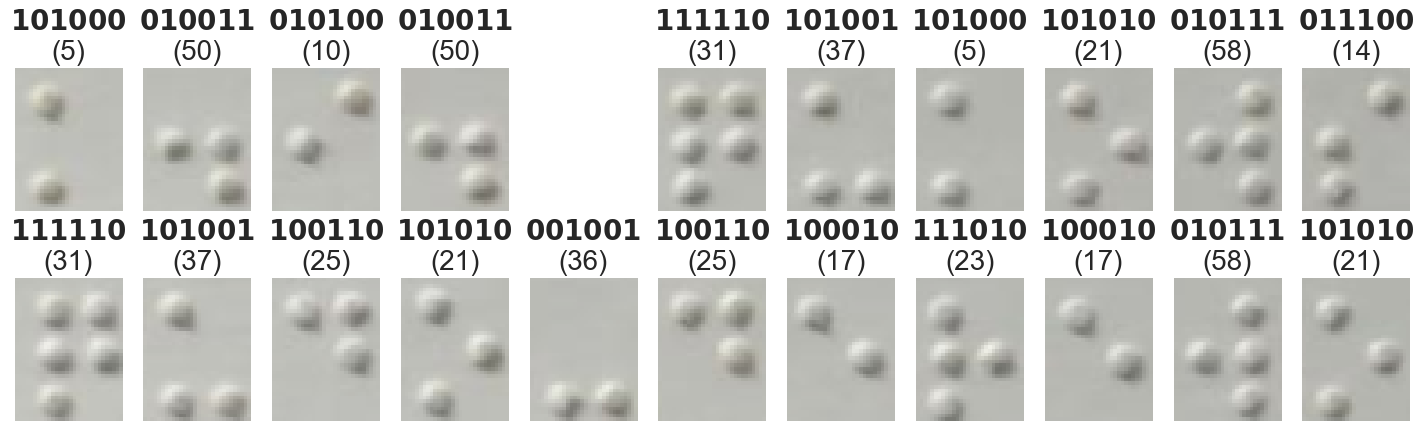

In [175]:
W = 18
fig, axes = plt.subplots(2, 11, figsize=(W,5))

for i, (img, lbl) in enumerate(zip(samples_x, samples_y)):
    sample = img / 255.
    plt_ix = i + int(i>3)
    ax = axes[plt_ix // 11, plt_ix % 11]
    ax.axis("off")
    ax.imshow(sample)
    bin_lbl = num_to_bin_string(lbl)
    ax.set_title(r"$\bf{" + str(bin_lbl) + "}$" + "\n({})".format(lbl),
                 fontsize=LBL_LARGE)
axes[0, 4].axis('off')
fig.savefig(os.path.join(PLOTS, 'extracted_chars.png'), bbox_inches='tight')
# plt.tight_layout()

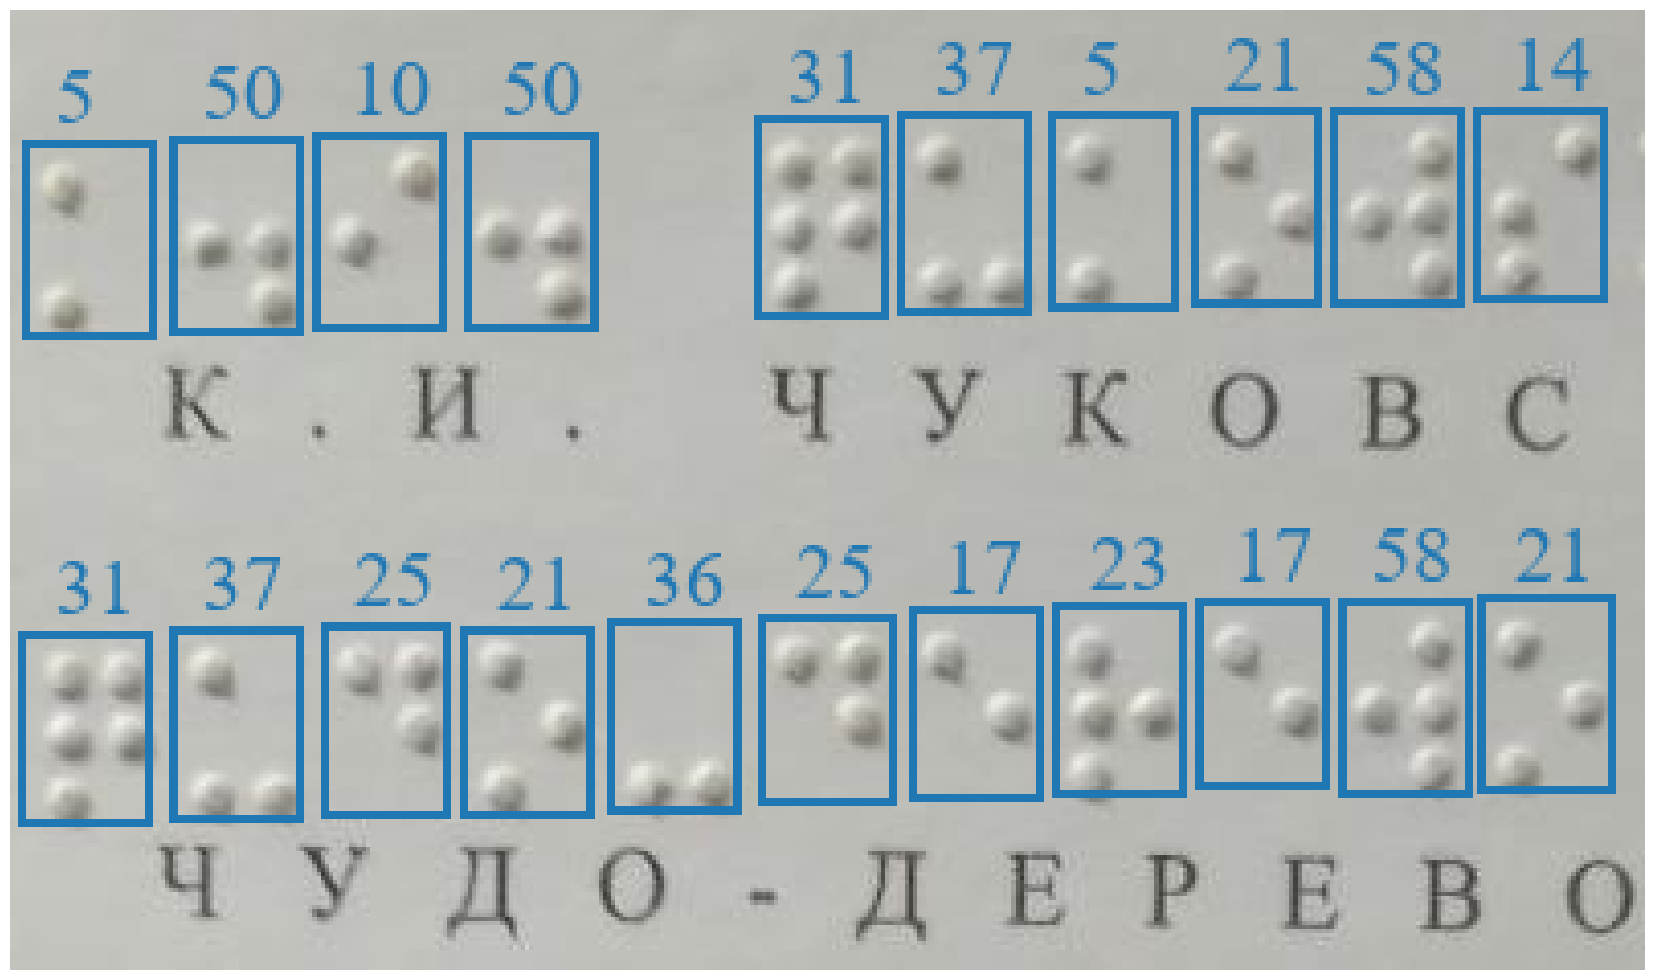

In [174]:

plt.figure(figsize=(W,floor(W/1.7)))
subset_annotated = np.array(pil_page)[y0:y1,x0:x1,:]
plt.imshow(subset_annotated)
plt.axis('off')
plt.savefig(os.path.join(PLOTS, 'labeled_page.png'), bbox_inches='tight')
plt.tight_layout()

## Data processing

In [14]:
angelina = os.path.join(DATASETS, "angelina.npz")
dsbi = os.path.join(DATASETS, "dsbi.npz")
abc = os.path.join(DATASETS, "abc.npz")
bcd = os.path.join(DATASETS, "bcd.npz")
b37 = os.path.join(DATASETS, "b37.npz")

data = np.load(angelina)
ood_dsbi = np.load(dsbi)
ood_abc = np.load(abc)
ood_bcd = np.load(bcd)
ood_b37 = np.load(b37)
print(data['train_x'].shape)
print(ood_dsbi['test_x'].shape)
print(ood_abc['test_x'].shape)
print(ood_bcd['test_x'].shape)
print(ood_b37['test_x'].shape)

(69267, 40, 30, 3)
(45627, 40, 30, 3)
(3168, 40, 30, 3)
(1560, 40, 30, 3)
(30608, 40, 30, 3)


In [15]:
train_X = data["train_x"] / 255.
train_Y = data["train_y"]


# val_X = data["val_x"] / 255.
val_Y = data["val_y"]

# test_X = data["test_x"] / 255.
test_Y = data["test_y"]

# dsbi_X = ood_dsbi['test_x'] / 255.
dsbi_Y = ood_dsbi['test_y']

# abc_X = ood_abc['test_x'] / 255.
abc_Y = ood_abc['test_y']

# bcd_X = ood_bcd['test_x'] / 255.
bcd_Y = ood_bcd['test_y']

# b37_X = ood_b37['test_x'] / 255.
b37_Y = ood_b37['test_y']

N, p = train_Y.shape

In [16]:
train_Y_cat = ml_to_mc(train_Y)
val_Y_cat = ml_to_mc(val_Y)
test_Y_cat = ml_to_mc(test_Y)
test_Y_str = bin_to_string(test_Y)

C = train_Y_cat.shape[1]

In [17]:

dsbi_Y_cat = ml_to_mc(dsbi_Y)
dsbi_Y_str = bin_to_string(dsbi_Y)

abc_Y_cat = ml_to_mc(abc_Y)
abc_Y_str = bin_to_string(abc_Y)

bcd_Y_cat = ml_to_mc(bcd_Y)
bcd_Y_str = bin_to_string(bcd_Y)

b37_Y_cat = ml_to_mc(b37_Y)
b37_Y_str = bin_to_string(b37_Y)

In [18]:
np.where(ml_to_mc(train_Y).sum(axis=0) == 0)

(array([ 0, 41], dtype=int64),)

In [19]:
print(train_X.shape)
# print(val_X.shape)
# print(test_X.shape)
# # print(dsbi_X.shape)

(69267, 40, 30, 3)


In [20]:
del data, ood_dsbi, ood_abc, ood_bcd, ood_b37

## Dataset analysis

In [21]:
from model_utils.augment import rotate_sample, y_mirror_sample, x_mirror_sample
from model_utils.augment import rotate_label, y_mirror_label, x_mirror_label

### Compute resampled datasets

In [22]:
T = 0.075
RAND = 2024
EPSIL = 0.05

with open(os.path.join(MODEL_PATH, 'base_ml_model_v2', 'history.json'), 'r') as ml_hist_json:
    base_ml_sample_diff = np.array(json.load(ml_hist_json)['history']['sample_difficulty'])
with open(os.path.join(MODEL_PATH, 'base_mc_model_v2', 'history.json'), 'r') as mc_hist_json:
    base_mc_sample_diff = np.array(json.load(mc_hist_json)['history']['sample_difficulty'])
base_mean_sample_diff = (base_ml_sample_diff + base_mc_sample_diff) / 2
undersample_candidates = base_mean_sample_diff <= T

sample_diffs = pd.DataFrame({
    'ml_sample_diff': base_ml_sample_diff,
    'mc_sample_diff': base_mc_sample_diff,
    'mean_sample_diff': base_mean_sample_diff,
})

In [23]:

label_augments, iter_stats_lb = label_balance_resample(train_Y, undersample_candidates, EPSIL, return_iters=True)
_, train_Y_lb = apply_augmentations(train_X, train_Y, augments=label_augments, shuffle=True, random_state=RAND, apply_train=False)
train_Y_cat_lb = ml_to_mc(train_Y_lb)


No more resampling / undersampling candidates. Ending augmentation after 13 iterations.


In [24]:

class_augments, iter_stats_cb = class_balance_resample(train_Y, undersample_candidates, EPSIL, return_iters=True)
_, train_Y_cb = apply_augmentations(train_X, train_Y, augments=class_augments, shuffle=True, random_state=RAND, apply_train=False)
train_Y_cat_cb = ml_to_mc(train_Y_cb)


All classes balanced as much as possible


c:\Users\User\OneDrive\Uni\Braille Research\Braille ML\src\model_utils\augment.py:184: RuntimeWarning: All-NaN slice encountered
  min_f, max_f = np.nanmin(class_weights), np.nanmax(class_weights)


In [25]:

adapt_augments, iter_stats_ab = adaptive_resample(train_Y, train_Y_cat, sample_diffs, return_iters=True)
_, train_Y_ab = apply_augmentations(train_X, train_Y, augments=adapt_augments, shuffle=True, random_state=RAND, apply_train=False)
train_Y_cat_ab = ml_to_mc(train_Y_ab)

Imbalance sufficiently reduced: class balance 0.9596775860353248 and max correlation 0.09887749651839162


### Visualise resampling iterations

In [182]:

def label_correlations(data_y, agg_absolute=False):
    K = data_y.shape[1]
    cov = np.cov(data_y.T)
    D = 1 / np.sqrt(np.diag(cov))
    label_corrs = D * cov * D.reshape((-1,1))
    np.fill_diagonal(label_corrs, np.nan)
    
    agg_label_corrs = np.abs(label_corrs) if agg_absolute else label_corrs
    
    corr_mean = np.nanmean(agg_label_corrs)
    corr_std = np.sqrt(np.nansum((agg_label_corrs - corr_mean) ** 2 / (K - 1)))
    
    return corr_mean, corr_std, label_corrs

<Axes: >

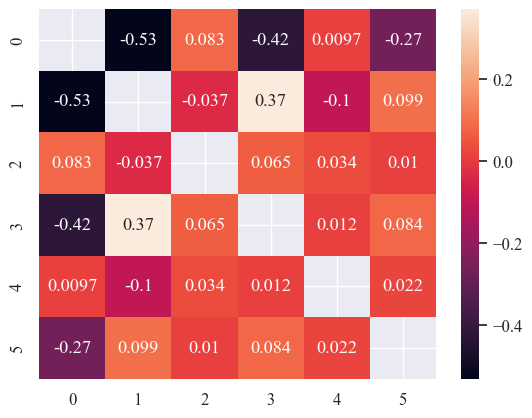

In [183]:
sns.heatmap(label_correlations(train_Y)[2], annot=True)

<Axes: >

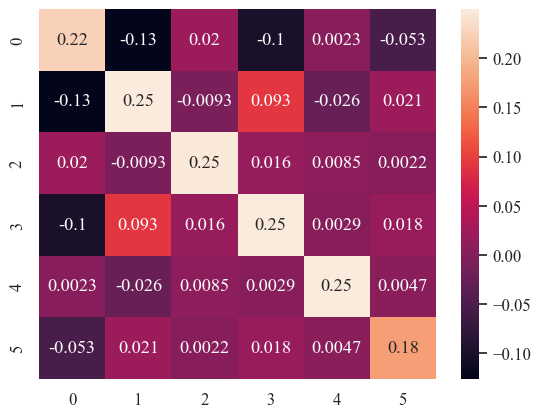

In [176]:
K = train_Y.shape[1]
cov = np.cov(train_Y.T)
sns.heatmap(cov, annot=True)

In [177]:
D = 1 / np.sqrt(np.diag(cov))
D

array([2.10873599, 2.00033088, 2.01413845, 2.00268768, 2.00284653,
       2.38619106])

In [ ]:

nr_cb = class_balance(train_Y_cat)
nr_cf = class_frequency(train_Y_cat)
nr_lf = class_frequency(train_Y)

nr_corr_m, nr_corr_std, nr_corr = label_correlations(train_Y, True)

iter_stats_cb.keys()

dict_keys(['class_imbalance', 'class_frequency_std', 'label_correlations', 'label_frequency_std', 'label_frequency_means'])

In [46]:
resamplings = ['NR', 'CR', 'LR', 'AR']

In [70]:
iter_stats_cb['label_correlations']

[array([[        nan, -0.50423759,  0.07930991, -0.40357122,  0.00917655,
         -0.30092178],
        [-0.56037139,         nan, -0.03770742,  0.37199993, -0.10337111,
          0.11847542],
        [ 0.08693471, -0.0371922 ,         nan,  0.06448542,  0.03418347,
          0.01232996],
        [-0.44744344,  0.37112489,  0.06522494,         nan,  0.01165774,
          0.1005565 ],
        [ 0.01017251, -0.1031116 ,  0.03457   ,  0.01165589,         nan,
          0.02654503],
        [-0.23501068,  0.08325714,  0.00878476,  0.07083146,  0.01870114,
                 nan]]),
 array([[        nan, -0.49335781,  0.00381016, -0.3457322 , -0.07235931,
         -0.20731718],
        [-0.53090453,         nan,  0.07846474,  0.27188867,  0.01285156,
         -0.00308135],
        [ 0.00412543,  0.07894896,         nan,  0.12066255, -0.01587433,
          0.00530485],
        [-0.37296763,  0.2725637 ,  0.12022023,         nan,  0.07244299,
          0.09391353],
        [-0.07807455,  0.012

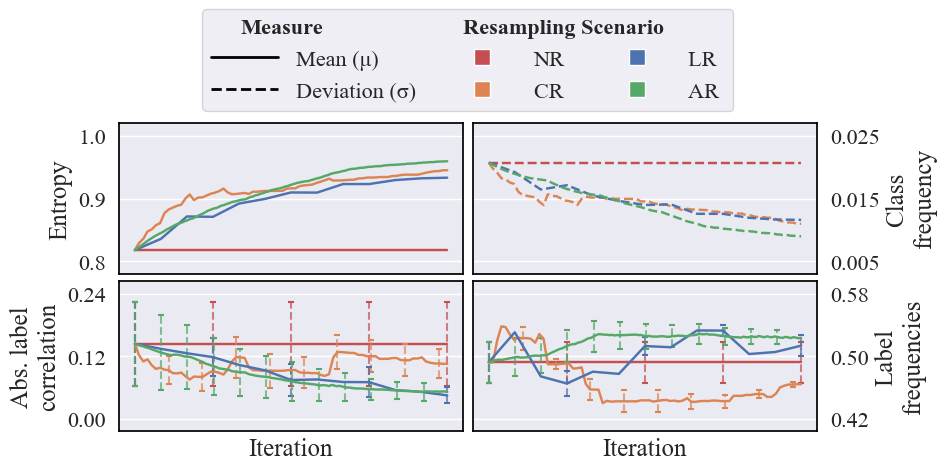

In [161]:
fig, axes = plt.subplots(2,2,figsize=(9,4), sharex='col')

ICB = len(iter_stats_cb['class_imbalance'])
iters_cb = np.linspace(0, 1, ICB)
ILB = len(iter_stats_lb['class_imbalance'])
iters_lb = np.linspace(0, 1, ILB)
IAB = len(iter_stats_ab['class_imbalance'])
iters_ab = np.linspace(0, 1, IAB)

m_stl = '-'
std_stl = '--'
std_scale = 0.2

# Entropy
if True:
    ax = axes[0,0]
    sns.lineplot(x=[0,1], y=[nr_cb, nr_cb], color=CPAL[0], linewidth=1.75, linestyle=m_stl,
                zorder=1, ax=ax)
    sns.lineplot(x=iters_cb, y=iter_stats_cb['class_imbalance'], color=CPAL[1], linewidth=1.75, linestyle=m_stl,
                    zorder=2, ax=ax)
    sns.lineplot(x=iters_lb, y=iter_stats_lb['class_imbalance'], color=CPAL[2], linewidth=1.75, linestyle=m_stl,
                    zorder=2, ax=ax)
    sns.lineplot(x=iters_ab, y=iter_stats_ab['class_imbalance'], color=CPAL[3], linewidth=1.75, linestyle=m_stl,
                    zorder=2, ax=ax)

    ax.set_ylabel('Entropy', fontsize=LBL_SIZE)
    ax.tick_params(axis='both', labelsize=TICK_SIZE)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1, 0.8))
    ax.set_ylim((0.78, 1.02))

# Class Freq
if True:
    ax = axes[0,1]
    sns.lineplot(x=[0,1], y=[np.std(nr_cf)]*2, color=CPAL[0], linewidth=1.75, linestyle=std_stl,
                zorder=1, ax=ax)
    sns.lineplot(x=iters_cb, y=iter_stats_cb['class_frequency_std'], color=CPAL[1], linewidth=1.75, linestyle=std_stl,
                    zorder=2, ax=ax)
    sns.lineplot(x=iters_lb, y=iter_stats_lb['class_frequency_std'], color=CPAL[2], linewidth=1.75, linestyle=std_stl,
                    zorder=2, ax=ax)
    sns.lineplot(x=iters_ab, y=iter_stats_ab['class_frequency_std'], color=CPAL[3], linewidth=1.75, linestyle=std_stl,
                    zorder=2, ax=ax)

    ax.set_ylabel('Class\nfrequency', fontsize=LBL_SIZE)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.01, 0.005))
    ax.yaxis.set_label_position("right")
    ax.tick_params(axis='y', which='both', labelleft=False, left=False, right=False, labelright=True)
    ax.tick_params(axis='both', labelsize=TICK_SIZE)
    ax.set_ylim((0.003, 0.027))

def abs_nan_mean(xlist):
    return [np.nanmean(np.abs(x)) for x in xlist]

def abs_nan_std(xlist, scale=1):
    K = xlist[0].shape[1]
    means = abs_nan_mean(xlist)
    return [scale * np.sqrt(np.nansum((np.abs(x) - m) ** 2 / (K - 1))) for x, m in zip(xlist, means)]

def abs_nan_sterr(xlist, scale=None):
    n = xlist[0].shape[1] * xlist[0].shape[0]
    return abs_nan_std(xlist, scale = 1 / np.sqrt(n))

# Label Corr
if True:
    ax = axes[1,0]
    n_errs = 5
    err_ev = 5
    # sns.lineplot(x=[0,1], y=[np.nanmax(np.abs(nr_corr))]*2, color=CPAL[0], linewidth=2., linestyle=':',
    #             zorder=1, ax=ax)
    errorbar_plot = ax.errorbar(np.linspace(0,1,n_errs), [nr_corr_m]*n_errs, yerr=[nr_corr_std * std_scale]*n_errs, color=CPAL[0], linewidth=1.75,
                                zorder=1, linestyle=m_stl, elinewidth=1.5, capsize=2, capthick=1.5)
    for bar in errorbar_plot[2]:
        bar.set_linestyle(std_stl)
        bar.set_alpha(0.7)
    errorbar_plot = ax.errorbar(iters_cb, y=abs_nan_mean(iter_stats_cb['label_correlations']),
                yerr=abs_nan_std(iter_stats_cb['label_correlations'], scale=std_scale), color=CPAL[1], linewidth=1.75,
                    zorder=2, linestyle=m_stl,
                    # errorevery=err_ev,
                    # errorevery=max(1, ICB // n_errs),
                    errorevery=max(1, int(np.sqrt(ICB))),
                    elinewidth=1.5, capsize=2, capthick=1.5)
    for bar in errorbar_plot[2]:
        bar.set_linestyle(std_stl)
        bar.set_alpha(0.7)
    errorbar_plot = ax.errorbar(iters_lb, y=abs_nan_mean(iter_stats_lb['label_correlations']),
                yerr=abs_nan_std(iter_stats_lb['label_correlations'], scale=std_scale), color=CPAL[2], linewidth=1.75,
                    zorder=2, linestyle=m_stl,
                    # errorevery=err_ev,
                    # errorevery=max(1, ILB // n_errs),
                    errorevery=max(1, int(np.sqrt(ILB))),
                    elinewidth=1.5, capsize=2, capthick=1.5)
    for bar in errorbar_plot[2]:
        bar.set_linestyle(std_stl)
        bar.set_alpha(0.7)
    errorbar_plot = ax.errorbar(iters_ab, y=abs_nan_mean(iter_stats_ab['label_correlations']),
                yerr=abs_nan_std(iter_stats_ab['label_correlations'], scale=std_scale), color=CPAL[3], linewidth=1.75,
                    zorder=2, linestyle=m_stl,
                    # errorevery=err_ev,
                    # errorevery=max(1, IAB // n_errs),
                    errorevery=max(1, int(np.sqrt(IAB))),
                    elinewidth=1.5, capsize=2, capthick=1.5)
    for bar in errorbar_plot[2]:
        bar.set_linestyle(std_stl)
        bar.set_alpha(0.7)

    ax.set_xticks([], [])
    ax.set_xlabel('Iteration', fontsize=LBL_SIZE)
    ax.set_ylabel('Abs. label\ncorrelation', fontsize=LBL_SIZE)
    ax.tick_params(axis='both', labelsize=TICK_SIZE)

    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.12, 0.0))
    ax.set_ylim((0-0.4*0.06, 0.24+0.4*0.06))

# Label Freq
if True:
    ax = axes[1,1]
    n_errs = 5
    err_ev = 5
    # sns.lineplot(x=[0,1], y=[nr_corr_m]*2, color=CPAL[0], linewidth=1.75,
    #             zorder=1, ax=ax)
    errorbar_plot = ax.errorbar(np.linspace(0,1,n_errs), [np.mean(nr_lf)]*n_errs, yerr=[std_scale * np.std(nr_lf)]*n_errs, color=CPAL[0], linewidth=1.75,
                                zorder=1, linestyle=m_stl, elinewidth=1.5, capsize=2, capthick=1.5)
    for bar in errorbar_plot[2]:
        bar.set_linestyle(std_stl)
        bar.set_alpha(0.7)
    errorbar_plot = ax.errorbar(iters_cb, y=iter_stats_cb['label_frequency_means'],
                yerr=[std_scale * s for s in iter_stats_cb['label_frequency_std']], color=CPAL[1], linewidth=1.75,
                    zorder=2, linestyle=m_stl,
                    # errorevery=err_ev,
                    # errorevery=max(1, ICB // n_errs),
                    errorevery=max(1, int(np.sqrt(ICB))),
                    elinewidth=1.5, capsize=2, capthick=1.5)
    for bar in errorbar_plot[2]:
        bar.set_linestyle(std_stl)
        bar.set_alpha(0.7)
    errorbar_plot = ax.errorbar(iters_lb, y=iter_stats_lb['label_frequency_means'],
                yerr=[std_scale * s for s in iter_stats_lb['label_frequency_std']], color=CPAL[2], linewidth=1.75,
                    zorder=2, linestyle=m_stl,
                    # errorevery=err_ev,
                    # errorevery=max(1, ILB // n_errs),
                    errorevery=max(1, int(np.sqrt(ILB))),
                    elinewidth=1.5, capsize=2, capthick=1.5)
    for bar in errorbar_plot[2]:
        bar.set_linestyle(std_stl)
        bar.set_alpha(0.7)
    errorbar_plot = ax.errorbar(iters_ab, y=iter_stats_ab['label_frequency_means'],
                yerr=[std_scale * s for s in iter_stats_ab['label_frequency_std']], color=CPAL[3], linewidth=1.75,
                    zorder=2, linestyle=m_stl,
                    # errorevery=err_ev,
                    # errorevery=max(1, IAB // n_errs),
                    errorevery=max(1, int(np.sqrt(IAB))),
                    elinewidth=1.5, capsize=2, capthick=1.5)
    for bar in errorbar_plot[2]:
        bar.set_linestyle(std_stl)
        bar.set_alpha(0.7)

    ax.set_xticks([], [])
    ax.set_xlabel('Iteration', fontsize=LBL_SIZE)
    ax.set_ylabel('Label\nfrequencies', fontsize=LBL_SIZE)

    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.08, 0.5))
    ax.yaxis.set_label_position("right")
    ax.tick_params(axis='y', which='both', labelleft=False, left=False, right=False, labelright=True)
    ax.tick_params(axis='both', labelsize=TICK_SIZE)
    ax.set_ylim((0.42-0.4*0.04, 0.58+0.4*0.04))


# Legend
if True:
    ax = axes[0,0]
    lg1 = ax.legend(handles=[
        Line2D([0], [0], color='none', label="Measure"),
        Line2D([0], [0], color='none', label="Resampling Scenario")
        ],
            loc='lower center', bbox_to_anchor=(1.015, 1.01),
            handlelength=0.5, columnspacing=5.,
            fontsize=TICK_SIZE, ncols=2,
            )
    rm_handles = [
        Line2D([0], [0], color=BLACK, marker='s', markersize=0,
            linewidth=2., label="Mean (\u03BC)", linestyle=m_stl
        ),
        Line2D([0], [0], color=BLACK, marker='s', markersize=0,
            linewidth=2., label="Deviation (\u03C3)", linestyle=std_stl
        )
        ] + [
        Line2D([0], [0], color='none',
            marker='s', markersize=12,
            # linewidth=2.,
            markeredgecolor=WHITE,
            markerfacecolor=CPAL[r],
            label=f"{res} "
        ) for r, res in enumerate(resamplings)
    ]
    lg2 = mlegend.Legend(ax,
                        handles=rm_handles,
                        labels=[h.get_label() for h in rm_handles],
                        fontsize=TICK_SIZE, 
                        handlelength=3.0, columnspacing=1.5,
                        loc='upper left', bbox_to_anchor=(1., 0.9), ncol=3, frameon=False)

    legends = [
        lg1, lg2
    ]
    # Manually combine the legends
    for leg in legends[1:]:
        for child in leg._legend_box._children:
            lg1._legend_box._children.append(child)
    lg1._legend_box.align = "left"

    bold_labels = ["Measure", "Resampling Scenario"]
    for lts in [leg.get_texts() for leg in legends]:
        for text in lts:
            t = text.get_text()
            if t in bold_labels:
                text.set_fontweight('bold')
                text.set_fontsize(TICK_SIZE)
            
plt.subplots_adjust(hspace=0.05, wspace=0.03)
# plt.savefig(os.path.join(PLOT_DATA, "resampling_iterations.pdf"), bbox_inches='tight')

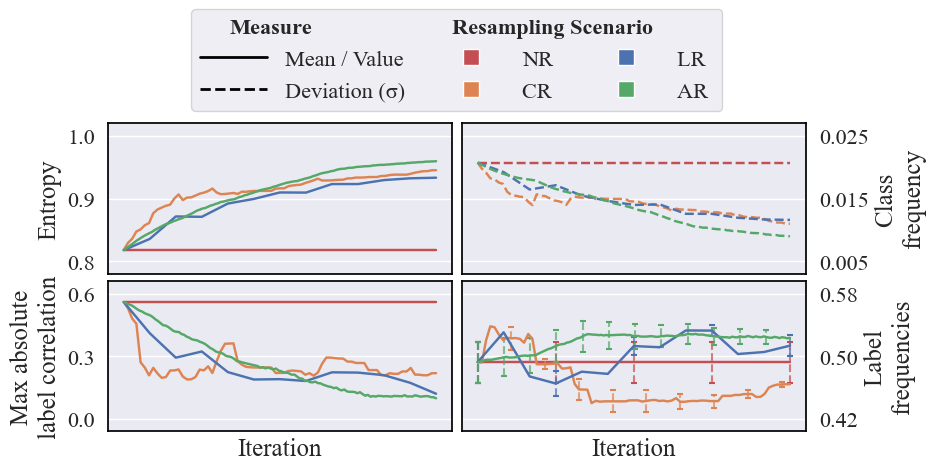

In [173]:
fig, axes = plt.subplots(2,2,figsize=(9,4), sharex='col')

ICB = len(iter_stats_cb['class_imbalance'])
iters_cb = np.linspace(0, 1, ICB)
ILB = len(iter_stats_lb['class_imbalance'])
iters_lb = np.linspace(0, 1, ILB)
IAB = len(iter_stats_ab['class_imbalance'])
iters_ab = np.linspace(0, 1, IAB)

m_stl = '-'
std_stl = '--'
std_scale = 0.2

# Entropy
if True:
    ax = axes[0,0]
    sns.lineplot(x=[0,1], y=[nr_cb, nr_cb], color=CPAL[0], linewidth=1.75, linestyle=m_stl,
                zorder=1, ax=ax)
    sns.lineplot(x=iters_cb, y=iter_stats_cb['class_imbalance'], color=CPAL[1], linewidth=1.75, linestyle=m_stl,
                    zorder=2, ax=ax)
    sns.lineplot(x=iters_lb, y=iter_stats_lb['class_imbalance'], color=CPAL[2], linewidth=1.75, linestyle=m_stl,
                    zorder=2, ax=ax)
    sns.lineplot(x=iters_ab, y=iter_stats_ab['class_imbalance'], color=CPAL[3], linewidth=1.75, linestyle=m_stl,
                    zorder=2, ax=ax)

    ax.set_ylabel('Entropy', fontsize=LBL_SIZE)
    ax.tick_params(axis='both', labelsize=TICK_SIZE)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1, 0.8))
    ax.set_ylim((0.78, 1.02))

# Class Freq
if True:
    ax = axes[0,1]
    # n_errs = 10
    # err_ev = 3
    # errorbar_plot = ax.errorbar(np.linspace(0,1,n_errs), [np.mean(nr_cf)]*n_errs, yerr=[std_scale * np.std(nr_cf)]*n_errs, color=CPAL[0], linewidth=1.75,
    #                             zorder=1, linestyle=m_stl, elinewidth=1.5, capsize=2, capthick=1.5)
    # for bar in errorbar_plot[2]:
    #     bar.set_linestyle(std_stl)
    #     bar.set_alpha(0.7)
    # errorbar_plot = ax.errorbar(iters_cb, y=[0.0157 for s in iter_stats_cb['class_frequency_std']],
    #             yerr=[std_scale * s for s in iter_stats_cb['class_frequency_std']], color=CPAL[1], linewidth=1.75,
    #                 zorder=2, linestyle=m_stl,
    #                 # errorevery=err_ev,
    #                 # errorevery=max(1, ICB // n_errs),
    #                 errorevery=max(1, int(np.sqrt(ICB))),
    #                 elinewidth=1.5, capsize=2, capthick=1.5)
    # for bar in errorbar_plot[2]:
    #     bar.set_linestyle(std_stl)
    #     bar.set_alpha(0.7)
    # errorbar_plot = ax.errorbar(iters_lb, y=[0.0157 for s in iter_stats_lb['class_frequency_std']],
    #             yerr=[std_scale * s for s in iter_stats_lb['class_frequency_std']], color=CPAL[2], linewidth=1.75,
    #                 zorder=2, linestyle=m_stl,
    #                 # errorevery=err_ev,
    #                 # errorevery=max(1, ILB // n_errs),
    #                 errorevery=max(1, int(np.sqrt(ILB))),
    #                 elinewidth=1.5, capsize=2, capthick=1.5)
    # for bar in errorbar_plot[2]:
    #     bar.set_linestyle(std_stl)
    #     bar.set_alpha(0.7)
    # errorbar_plot = ax.errorbar(iters_ab, y=[0.0157 for s in iter_stats_ab['class_frequency_std']],
    #             yerr=[std_scale * s for s in iter_stats_ab['class_frequency_std']], color=CPAL[3], linewidth=1.75,
    #                 zorder=2, linestyle=m_stl,
    #                 # errorevery=err_ev,
    #                 # errorevery=max(1, IAB // n_errs),
    #                 errorevery=max(1, int(np.sqrt(IAB))),
    #                 elinewidth=1.5, capsize=2, capthick=1.5)
    # for bar in errorbar_plot[2]:
    #     bar.set_linestyle(std_stl)
    #     bar.set_alpha(0.7)
        
    sns.lineplot(x=[0,1], y=[np.std(nr_cf)]*2, color=CPAL[0], linewidth=1.75, linestyle=std_stl,
                zorder=1, ax=ax)
    sns.lineplot(x=iters_cb, y=iter_stats_cb['class_frequency_std'], color=CPAL[1], linewidth=1.75, linestyle=std_stl,
                    zorder=2, ax=ax)
    sns.lineplot(x=iters_lb, y=iter_stats_lb['class_frequency_std'], color=CPAL[2], linewidth=1.75, linestyle=std_stl,
                    zorder=2, ax=ax)
    sns.lineplot(x=iters_ab, y=iter_stats_ab['class_frequency_std'], color=CPAL[3], linewidth=1.75, linestyle=std_stl,
                    zorder=2, ax=ax)

    ax.set_ylabel('Class\nfrequency', fontsize=LBL_SIZE)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.01, 0.005))
    ax.yaxis.set_label_position("right")
    ax.tick_params(axis='y', which='both', labelleft=False, left=False, right=False, labelright=True)
    ax.tick_params(axis='both', labelsize=TICK_SIZE)
    ax.set_ylim((0.003, 0.027))

def abs_nan_mean(xlist):
    return [np.nanmean(np.abs(x)) for x in xlist]

def abs_nan_std(xlist, scale=1):
    K = xlist[0].shape[1]
    means = abs_nan_mean(xlist)
    return [scale * np.sqrt(np.nansum((np.abs(x) - m) ** 2 / (K - 1))) for x, m in zip(xlist, means)]

def abs_nan_max(xlist):
    return [np.nanmax(np.abs(x)) for x in xlist]

# Label Corr
if True:
    ax = axes[1,0]
    scl = 0.25
    n_errs = 5
    err_ev = 5
    sns.lineplot(x=[0,1], y=[np.nanmax(np.abs(nr_corr))]*2, color=CPAL[0], linewidth=1.75, linestyle=m_stl,
                zorder=1, ax=ax)
    sns.lineplot(x=iters_cb, y=abs_nan_max(iter_stats_cb['label_correlations']), color=CPAL[1], linewidth=1.75, linestyle=m_stl,
                    zorder=2, ax=ax)
    sns.lineplot(x=iters_lb, y=abs_nan_max(iter_stats_lb['label_correlations']), color=CPAL[2], linewidth=1.75, linestyle=m_stl,
                    zorder=2, ax=ax)
    sns.lineplot(x=iters_ab, y=abs_nan_max(iter_stats_ab['label_correlations']), color=CPAL[3], linewidth=1.75, linestyle=m_stl,
                    zorder=2, ax=ax)
    
    # sns.lineplot(x=[0,1], y=[scl * nr_corr_std]*2, color=CPAL[0], linewidth=1.75, linestyle=std_stl,
    #             zorder=1, ax=ax)
    # sns.lineplot(x=iters_cb, y=abs_nan_std(iter_stats_cb['label_correlations'], scale=scl), color=CPAL[1], linewidth=1.75, linestyle=std_stl,
    #                 zorder=2, ax=ax)
    # sns.lineplot(x=iters_lb, y=abs_nan_std(iter_stats_lb['label_correlations'], scale=scl), color=CPAL[2], linewidth=1.75, linestyle=std_stl,
    #                 zorder=2, ax=ax)
    # sns.lineplot(x=iters_ab, y=abs_nan_std(iter_stats_ab['label_correlations'], scale=scl), color=CPAL[3], linewidth=1.75, linestyle=std_stl,
    #                 zorder=2, ax=ax)

    ax.set_xticks([], [])
    ax.set_xlabel('Iteration', fontsize=LBL_SIZE)
    ax.set_ylabel('Max absolute\nlabel correlation', fontsize=LBL_SIZE)
    ax.tick_params(axis='both', labelsize=TICK_SIZE)

    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.3, 0.0))
    ax.set_ylim((0-0.2*0.3, 0.6+0.2*0.3))

# Label Freq
if True:
    ax = axes[1,1]
    n_errs = 5
    err_ev = 5
    errorbar_plot = ax.errorbar(np.linspace(0,1,n_errs), [np.mean(nr_lf)]*n_errs, yerr=[std_scale * np.std(nr_lf)]*n_errs, color=CPAL[0], linewidth=1.75,
                                zorder=1, linestyle=m_stl, elinewidth=1.5, capsize=2, capthick=1.5)
    for bar in errorbar_plot[2]:
        bar.set_linestyle(std_stl)
        bar.set_alpha(0.7)
    errorbar_plot = ax.errorbar(iters_cb, y=iter_stats_cb['label_frequency_means'],
                yerr=[std_scale * s for s in iter_stats_cb['label_frequency_std']], color=CPAL[1], linewidth=1.75,
                    zorder=2, linestyle=m_stl,
                    # errorevery=err_ev,
                    # errorevery=max(1, ICB // n_errs),
                    errorevery=max(1, int(np.sqrt(ICB))),
                    elinewidth=1.5, capsize=2, capthick=1.5)
    for bar in errorbar_plot[2]:
        bar.set_linestyle(std_stl)
        bar.set_alpha(0.7)
    errorbar_plot = ax.errorbar(iters_lb, y=iter_stats_lb['label_frequency_means'],
                yerr=[std_scale * s for s in iter_stats_lb['label_frequency_std']], color=CPAL[2], linewidth=1.75,
                    zorder=2, linestyle=m_stl,
                    # errorevery=err_ev,
                    # errorevery=max(1, ILB // n_errs),
                    errorevery=max(1, int(np.sqrt(ILB))),
                    elinewidth=1.5, capsize=2, capthick=1.5)
    for bar in errorbar_plot[2]:
        bar.set_linestyle(std_stl)
        bar.set_alpha(0.7)
    errorbar_plot = ax.errorbar(iters_ab, y=iter_stats_ab['label_frequency_means'],
                yerr=[std_scale * s for s in iter_stats_ab['label_frequency_std']], color=CPAL[3], linewidth=1.75,
                    zorder=2, linestyle=m_stl,
                    # errorevery=err_ev,
                    # errorevery=max(1, IAB // n_errs),
                    errorevery=max(1, int(np.sqrt(IAB))),
                    elinewidth=1.5, capsize=2, capthick=1.5)
    for bar in errorbar_plot[2]:
        bar.set_linestyle(std_stl)
        bar.set_alpha(0.7)

    ax.set_xticks([], [])
    ax.set_xlabel('Iteration', fontsize=LBL_SIZE)
    ax.set_ylabel('Label\nfrequencies', fontsize=LBL_SIZE)

    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.08, 0.5))
    ax.yaxis.set_label_position("right")
    ax.tick_params(axis='y', which='both', labelleft=False, left=False, right=False, labelright=True)
    ax.tick_params(axis='both', labelsize=TICK_SIZE)
    ax.set_ylim((0.42-0.4*0.04, 0.58+0.4*0.04))


# Legend
if True:
    ax = axes[0,0]
    lg1 = ax.legend(handles=[
        Line2D([0], [0], color='none', label="Measure"),
        Line2D([0], [0], color='none', label="Resampling Scenario")
        ],
            loc='lower center', bbox_to_anchor=(1.015, 1.01),
            handlelength=0.5, columnspacing=5.,
            fontsize=TICK_SIZE, ncols=2,
            )
    rm_handles = [
        Line2D([0], [0], color=BLACK, marker='s', markersize=0,
            linewidth=2., label="Mean / Value", linestyle=m_stl
        ),
        Line2D([0], [0], color=BLACK, marker='s', markersize=0,
            linewidth=2., label="Deviation (\u03C3)", linestyle=std_stl
        )
        ] + [
        Line2D([0], [0], color='none',
            marker='s', markersize=12,
            # linewidth=2.,
            markeredgecolor=WHITE,
            markerfacecolor=CPAL[r],
            label=f"{res} "
        ) for r, res in enumerate(resamplings)
    ]
    lg2 = mlegend.Legend(ax,
                        handles=rm_handles,
                        labels=[h.get_label() for h in rm_handles],
                        fontsize=TICK_SIZE, 
                        handlelength=3.0, columnspacing=1.5,
                        loc='upper left', bbox_to_anchor=(1., 0.9), ncol=3, frameon=False)

    legends = [
        lg1, lg2
    ]
    # Manually combine the legends
    for leg in legends[1:]:
        for child in leg._legend_box._children:
            lg1._legend_box._children.append(child)
    lg1._legend_box.align = "left"

    bold_labels = ["Measure", "Resampling Scenario"]
    for lts in [leg.get_texts() for leg in legends]:
        for text in lts:
            t = text.get_text()
            if t in bold_labels:
                text.set_fontweight('bold')
                text.set_fontsize(TICK_SIZE)
            
plt.subplots_adjust(hspace=0.05, wspace=0.03)
plt.savefig(os.path.join(PLOT_DATA, "resampling_iterations.pdf"), bbox_inches='tight')

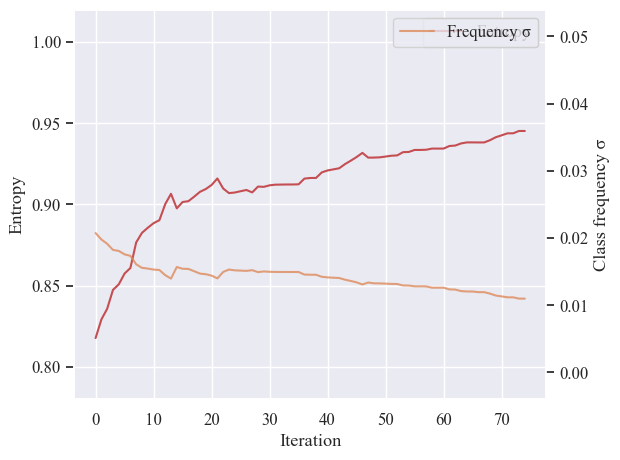

In [ ]:
I = len(iter_stats_cb['class_imbalance'])
iters = range(I)
ax = sns.lineplot(x=iters, y=iter_stats_cb['class_imbalance'], color=CPAL[0], label='Entropy', zorder=2)
# ax.errorbar(I, avg_abs_corrs, yerr=std_abs_corrs, fmt='.', color=PAL[1], alpha=0.75, zorder=0)
# sns.lineplot(x=I, y=max_abs_corrs, color=PAL[2], label='Max absolute correlation', zorder=1)
ax.set_xlabel('Iteration')
ax.set_ylabel('Entropy')

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05, 0.8))
ax.set_ylim((0.78, 1.02))

ax2 = ax.twinx()
ax2.grid(False)
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.01, 0.0))
ax2.set_ylim((-0.004, 0.054))
sns.lineplot(x=iters, y=iter_stats_cb['class_frequency_std'], color=CPAL[1], label='Frequency \u03C3', alpha=0.75,
             ax=ax2, zorder=1)
ax2.set_ylabel('Class frequency \u03C3')

plt.legend()
plt.tight_layout()

In [50]:
iter_stats_ab

{'class_imbalance': [0.8176877972486756,
  0.8208213239441425,
  0.8236262879665411,
  0.8266901138310206,
  0.8297517268229698,
  0.833031824456148,
  0.835673000229523,
  0.8383578708712647,
  0.8408836573951852,
  0.8431310266598955,
  0.8452311882021134,
  0.8473400325009971,
  0.8503044526774527,
  0.8523634571259028,
  0.8546614269951318,
  0.8569150275819467,
  0.8590806578709368,
  0.8602819257599097,
  0.8619573120984375,
  0.8638662161283863,
  0.8653058401637802,
  0.8671543962880689,
  0.8682055922972416,
  0.8701520503156457,
  0.8723808774622984,
  0.8742737667160894,
  0.8762340121550768,
  0.8785256736817925,
  0.8809309035807201,
  0.8823364380414869,
  0.8840957893269614,
  0.8848491122063016,
  0.8866491263611339,
  0.888664978874251,
  0.8896918381030352,
  0.891439582050186,
  0.8926343854238205,
  0.8945129203946499,
  0.8951785338401056,
  0.8964093818909836,
  0.8975011671561257,
  0.8983141493415601,
  0.8988215195187825,
  0.9003884476494556,
  0.9023747661299

### Visualise Samples, Augmentations and Labels

In [22]:
sample = train_X[train_Y_cat[:, 29] == 1, :][0]
sample_y = train_Y[train_Y_cat[:, 29] == 1, :][0:1]

In [33]:
y_mirror_label(sample_y)

array([[1, 1, 0, 1, 0, 1]])

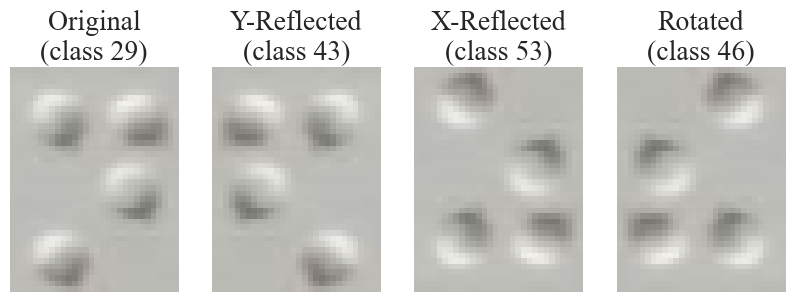

In [36]:
sample = train_X[train_Y_cat[:, 29] == 1, :][0]

fig, axes = plt.subplots(1, 4, figsize=(10,5))

axes[0].axis("off")
axes[0].imshow(sample)
lbl = bin_to_num(sample_y)[0]
axes[0].set_title(f"Original\n(class {lbl})", fontsize=LBL_LARGE)

axes[1].axis("off")
axes[1].imshow(y_mirror_sample(sample))
lbl = bin_to_num(y_mirror_label(sample_y))[0]
axes[1].set_title(f"Y-Reflected\n(class {lbl})", fontsize=LBL_LARGE)

axes[2].axis("off")
axes[2].imshow(x_mirror_sample(sample))
lbl = bin_to_num(x_mirror_label(sample_y))[0]
axes[2].set_title(f"X-Reflected\n(class {lbl})", fontsize=LBL_LARGE)

axes[3].axis("off")
axes[3].imshow(rotate_sample(sample))
lbl = bin_to_num(rotate_label(sample_y))[0]
axes[3].set_title(f"Rotated\n(class {lbl})", fontsize=LBL_LARGE)

plt.savefig(os.path.join(PLOTS, 'augmentations_example.png'), bbox_inches='tight')


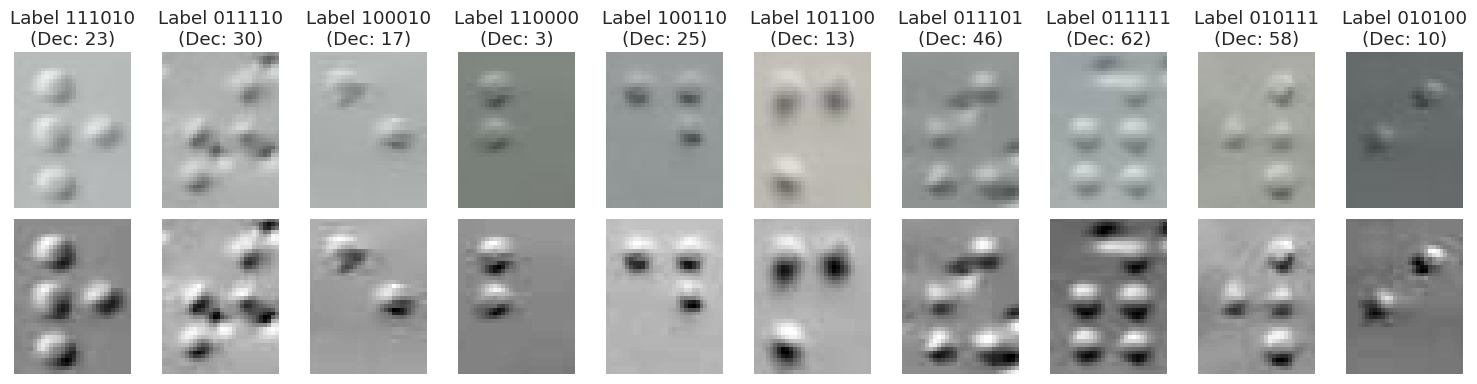

In [ ]:
plt.figure(figsize=(15,4))
np.random.seed(101010)
subset = np.random.choice(np.arange(0, N), 10)

for i in range(10):
    sample = (train_X[subset[i]]).astype(np.float32)
    plt.subplot(2,10, i+1)
    plt.axis("off")
    lbl = ''.join(train_Y[subset[i]].astype(str))
    num_lbl = np.argmax(train_Y_cat[subset[i]])
    plt.imshow(sample)
    plt.title("Label {}\n(Dec: {})".format(lbl, num_lbl))
    
    gray = cv2.cvtColor(sample, cv2.COLOR_RGB2GRAY)
    plt.subplot(2,10, i+11)
    plt.axis("off")
    plt.gray()
    plt.imshow(gray)
plt.tight_layout()

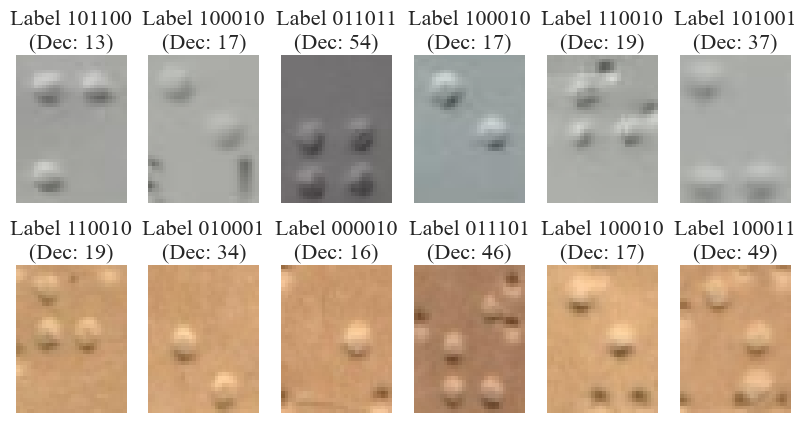

In [ ]:
plt.figure(figsize=(10,5))
np.random.seed(654321)
subset2 = np.random.choice(np.arange(0, len(dsbi_X)), 6)
subset1 = np.random.choice(np.arange(0, N), 6)

for i in range(6):
    sample = (train_X[subset1[i]]).astype(np.float32)
    plt.subplot(2,6, i+1)
    plt.axis("off")
    lbl = ''.join(train_Y[subset1[i]].astype(str))
    num_lbl = np.argmax(train_Y_cat[subset1[i]])
    plt.imshow(sample)
    plt.title("Label {}\n(Dec: {})".format(lbl, num_lbl), fontsize=TICK_SIZE)
    
    sample = (dsbi_X[subset2[i]]).astype(np.float32)
    plt.subplot(2,6, i+7)
    plt.axis("off")
    plt.imshow(sample)
    lbl = ''.join(dsbi_Y[subset2[i]].astype(str))
    num_lbl = np.argmax(dsbi_Y_cat[subset2[i]])
    plt.imshow(sample)
    plt.title("Label {}\n(Dec: {})".format(lbl, num_lbl), fontsize=TICK_SIZE)
# plt.tight_layout()
# plt.savefig(os.path.join(PLOT_DATA, "sample_characters.pdf"), bbox_inches='tight')

In [206]:
dsbi_Y_str

array(['010100', '101000', '001100', ..., '100011', '001101', '011101'],
      dtype='<U6')

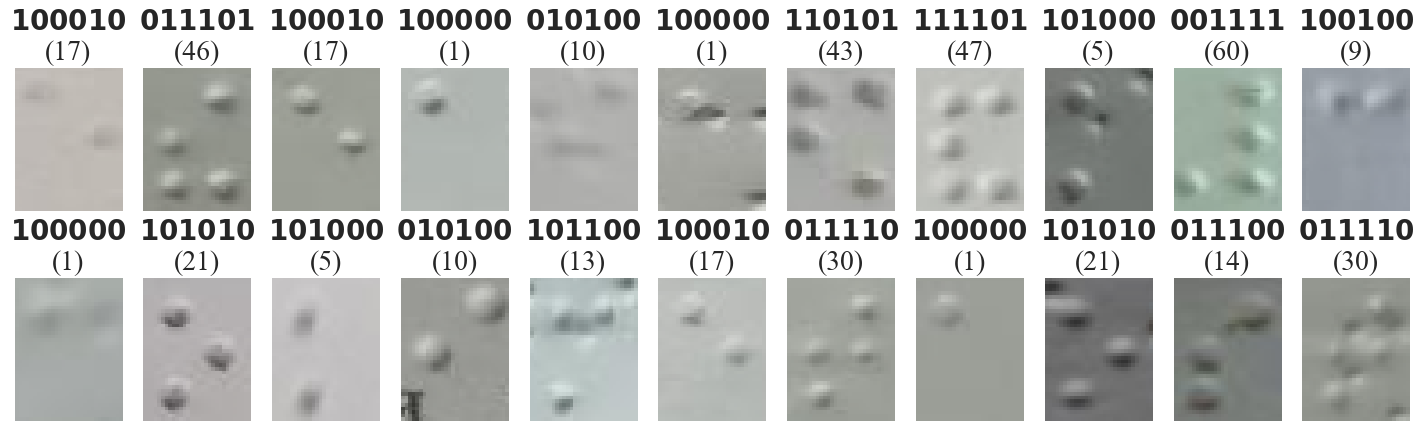

In [212]:
W = 18
fig, axes = plt.subplots(2, 11, figsize=(W,5))
np.random.seed(123456)
subset = np.random.choice(np.arange(0, N), 22)

samples_x = train_X[subset]
samples_y = train_Y[subset]

for i, (sample, lbl) in enumerate(zip(samples_x, samples_y)):
    # sample = img / 255.
    ax = axes[i // 11, i % 11]
    ax.axis("off")
    ax.imshow(sample)
    bin_lbl = ''.join(lbl.astype(str))
    dec_lbl = np.argmax(ml_to_mc(lbl))
    ax.set_title(r"$\bf{" + bin_lbl + "}$" + "\n({})".format(dec_lbl),
                 fontsize=LBL_LARGE)
# axes[0, 4].axis('off')
# plt.tight_layout()
plt.savefig(os.path.join(PLOT_DATA, "sample_train_characters.pdf"), bbox_inches='tight')

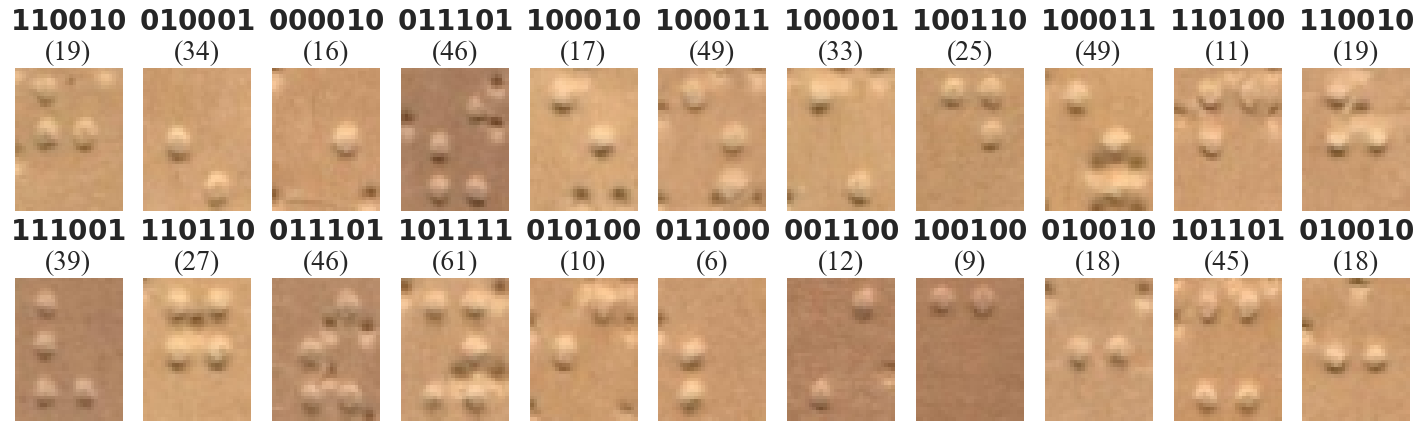

In [ ]:
W = 18
fig, axes = plt.subplots(2, 11, figsize=(W,5))
np.random.seed(654321)
subset = np.random.choice(np.arange(0, len(dsbi_X)), 22)

samples_x = dsbi_X[subset]
samples_y = dsbi_Y[subset]

for i, (sample, lbl) in enumerate(zip(samples_x, samples_y)):
    # sample = img / 255.
    ax = axes[i // 11, i % 11]
    ax.axis("off")
    ax.imshow(sample)
    bin_lbl = ''.join(lbl.astype(str))
    dec_lbl = np.argmax(ml_to_mc(lbl))
    ax.set_title(r"$\bf{" + bin_lbl + "}$" + "\n({})".format(dec_lbl),
                 fontsize=LBL_LARGE)
# axes[0, 4].axis('off')
# plt.tight_layout()
plt.savefig(os.path.join(PLOT_DATA, "sample_ood_characters.pdf"), bbox_inches='tight')

In [23]:
with open(os.path.join('..', 'dicts','english_lvl2.json')) as json_file:
    english_dict = json.load(json_file)

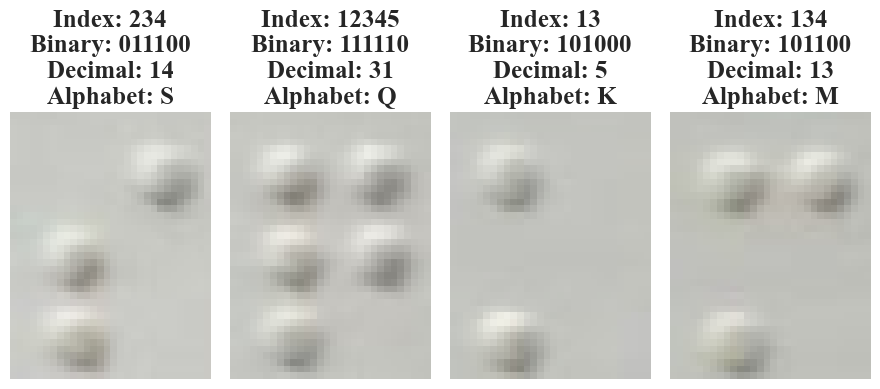

In [28]:
plt.figure(figsize=(9,5), facecolor=WHITE)
S = 4
K = 6
index_list = (np.arange(K) + 1)

for i in range(S):
    sample = train_X[i]
    plt.subplot(1,S, i+1)
    plt.axis("off")
    y = train_Y[i]
    
    index_lbl = ''.join(index_list[y.astype(bool)].astype(str))
    lbl = ''.join(y.astype(str))
    num_lbl = bin_to_num(y)
    eng_lbl = english_dict[lbl]
    plt.imshow(sample)
    plt.title("Index: {}\nBinary: {}\nDecimal: {}\nAlphabet: {}".format(index_lbl, lbl, num_lbl, eng_lbl),
              fontsize=LBL_SIZE, fontweight='bold')
    # plt.title("Index: {}\nBinary: {}\nInteger: {}".format(index_lbl, lbl, num_lbl),
    #           fontsize=18, fontweight='bold')

plt.tight_layout()

In [51]:
N

69267

In [53]:
{k: sum(v) for k, v in adapt_augments.items()}

{'undersample': 29750, 'rotate': 11900, 'xmir': 11900, 'ymir': 11900}

In [54]:
{
    'LB Resampled': (53700+42172+8953) / (N-30329+53700+42172+8953),
    'CB Resampled': (54115+30264+22294) / (N-30349+54115+30264+22294),
    'AB Resampled': (11900+11900+11900) / (N-29750+11900+11900+11900),
}

{'LB Resampled': 0.7291514506514194,
 'CB Resampled': 0.7326895206434464,
 'AB Resampled': 0.47462674661313264}

### Summarise Dataset Distributions

In [26]:
CPAL

[(0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941)]

TODO: Compare Class distributions across training sets, and across training-testing pairs.

TODO: Record Class Imbalance, and Label Correlation strength, per training and testing set, to investigate correlation with model performance.

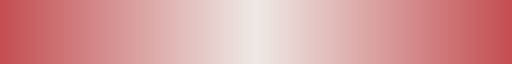

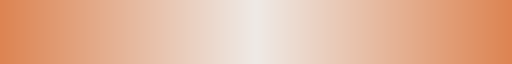

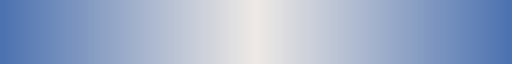

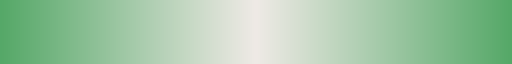

In [27]:
RCMAP = sns.blend_palette([
    RED,
    LIGHT,
    RED
], as_cmap=True)
OCMAP = sns.blend_palette([
    ORANGE,
    LIGHT,
    ORANGE
], as_cmap=True)
BCMAP = sns.blend_palette([
    BLUE,
    LIGHT,
    BLUE
], as_cmap=True)
GCMAP = sns.blend_palette([
    GREEN,
    LIGHT,
    GREEN
], as_cmap=True)

display(RCMAP)
display(OCMAP)
display(BCMAP)
display(GCMAP)

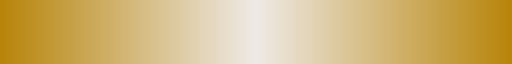

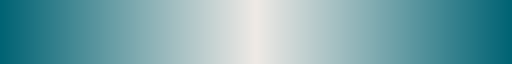

In [43]:

PCMAP = sns.blend_palette([
    TPAL[0],
    LIGHT,
    TPAL[0]
], as_cmap=True)
YCMAP = sns.blend_palette([
    TPAL[1],
    LIGHT,
    TPAL[1]
], as_cmap=True)
CCMAP = sns.blend_palette([
    TPAL[4],
    LIGHT,
    TPAL[4]
], as_cmap=True)

display(YCMAP)
display(CCMAP)

In [29]:
dataset_distributions = {
    
}

In [31]:
def summarise_dataset_lg(data_Y, data_Y_cat, name, agg_absolute=True,
                       main_col=BLUE, main_cmap=BCMAP):
    global dataset_distributions
    ts = TICK_SIZE

    cb = class_balance(data_Y_cat)
    cf = class_frequency(data_Y_cat)
    lf = class_frequency(data_Y)

    corr_m, corr_std, corr = label_correlations_v2(data_Y, agg_absolute)
    imb_m, imb_std, imb = between_label_imbalance(data_Y)
    mi = mean_mutual_information(data_Y)
    ticks = np.arange(len(lf))
    labels = ticks + 1
    
    dataset_distributions[name] = {
        'Class Frequencies': cf.tolist(),
        'Dot Frequencies': lf.tolist(),
        'Dot Correlations': (corr_m, corr_std, corr.tolist()),
        'Class Balance': cb,
    }

    plt.rcParams['axes.edgecolor'] = BLACK
    fig, axes = plt.subplots(1, 3, figsize=(12, 3), facecolor=WHITE)
    
    ax = axes[0]
    ax.bar(x=range(len(cf)), height=cf, color=main_col, linewidth=0.)
    # ax.set_title(f'Class balance\nEntropy {round(cb, 4)}',
    #           fontsize=LBL_SIZE, fontweight='bold')
    ax.set_title(f'Class frequencies\n\u03C3 (%) {round(np.std(cf)*100, 2)}; Entropy {round(cb, 2)}',
              fontsize=LBL_SIZE, fontweight='bold')
    ax.set_xlabel('Class index', fontsize=ts)
    ax.tick_params(axis='both', labelsize=ts, pad=-1)
    ax.set_ylim(0, 0.1)
    ax.set_yticks([0, 0.03, 0.06, 0.09], [0, 0.03, 0.06, 0.09])
    ax.tick_params(axis='y', which='both', labelleft=False, left=False, right=False, labelright=True)    
    ax.grid(axis='x', visible=False)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
    bxl = ax.get_xlim()
    ax.set_xlim(bxl)
    ref = 1 / len(cf)
    sns.lineplot(x=list(bxl), y=[ref]*2, color=BLACK, linestyle=':', alpha=0.65, ax=ax,
                zorder=3, linewidth=1.75, label=f"Ideal frequency {ref*100:.1f}%")
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
                     handlelength=1.5, fontsize=ts)


    ax = axes[1]

    ax.bar(x=range(len(lf)), height=lf, color=main_col, linewidth=0.)
    ax.set_title(f'Label frequencies\nAvg (%) {round(np.mean(lf)*100, 1)} \u00b1 {round(np.std(lf)*100, 1)}',
              fontsize=LBL_SIZE, fontweight='bold')
    ax.tick_params(axis='both', labelsize=ts, pad=-1)
    ax.set_xlabel('Label index', fontsize=ts,)
    ax.set_xticks(ticks, labels)
    
    bxl = ax.get_xlim()
    ax.set_xlim(bxl)
    ref = 0.5
    sns.lineplot(x=list(bxl), y=[ref]*2, color=BLACK, linestyle=':', alpha=0.65, ax=ax,
                zorder=3, linewidth=1.75, label=f"Ideal frequency {ref*100:.1f}%")
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
                     handlelength=1.5, fontsize=ts)
    ax.set_ylim(0, 0.7)
    ax.set_yticks([0, 0.3, 0.6], [0, 0.3, 0.6])
    ax.tick_params(axis='y', which='both', labelleft=False, left=False, right=False, labelright=True)
    ax.grid(axis='x', visible=False)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

    ax = axes[2]

    res = sns.heatmap(corr, annot=True, fmt='.2f', ax=ax, annot_kws={
            'fontweight': 'bold'
        }, vmin=-0.6, vmax=0.6, cmap=main_cmap,
        cbar=False,
        
    )
    for _, spine in res.spines.items(): 
        spine.set_visible(True)
        
    ax.tick_params(axis='y', which='both', labelleft=False, left=False, right=False, labelright=True)
    ax.set_facecolor(WHITE)
    cax = fig.add_axes([0.7, -0.15, 0.18, 0.05])
    
    norm = mpl_colors.Normalize(vmin=-0.6,vmax=0.6)
    sm = plt.cm.ScalarMappable(cmap=main_cmap, norm=norm)
    # sm.set_array([])
    cbar = plt.colorbar(sm, cax=cax, orientation='horizontal', ticks=np.linspace(-0.6,0.6,5), format=ticker.FormatStrFormatter('%.1f'))
    # cbar.gca().tick_params(axis='y', length=0, labelsize=TINY)
    cax.tick_params(axis='x', length=0, labelsize=ts)
    
    ax.set_title(f'Label correlations\nAvg {"(abs)" if agg_absolute else ""} {corr_m:.2f} \u00b1 {corr_std:.2f}',
              fontsize=LBL_SIZE, fontweight='bold')
    ax.set_xlabel('Label index', fontsize=ts)
    ax.tick_params(axis='both', labelsize=ts, pad=-1, labelrotation=0)
    ax.set_xticks(ticks+0.5, labels)
    ax.set_yticks(ticks+0.5, labels)
    # plt.title(f'Dot correlations of {name} set.\nMean correlation {round(corr_m, 3)} \u00b1 {round(corr_std, 2)}\nLabel mutual information {round(mi, 3)}')
    # plt.tight_layout()
    plt.subplots_adjust(wspace=0.25)
    return fig

In [32]:
def summarise_dataset(data_Y, data_Y_cat, name, agg_absolute=True,
                       main_col=BLUE, main_cmap=BCMAP):
    global dataset_distributions
    ts = TICK_SIZE-1

    cb = class_balance(data_Y_cat)
    cf = class_frequency(data_Y_cat)
    lf = class_frequency(data_Y)

    corr_m, corr_std, corr = label_correlations_v2(data_Y, agg_absolute)
    imb_m, imb_std, imb = between_label_imbalance(data_Y)
    mi = mean_mutual_information(data_Y)
    ticks = np.arange(len(lf))
    labels = ticks + 1
    
    dataset_distributions[name] = {
        'Class Frequencies': cf.tolist(),
        'Dot Frequencies': lf.tolist(),
        'Dot Correlations': (corr_m, corr_std, corr.tolist()),
        'Class Balance': cb,
    }

    plt.rcParams['axes.edgecolor'] = BLACK
    fig, axes = plt.subplots(1, 3, figsize=(12, 1.7), facecolor=WHITE)
    
    ax = axes[0]
    ax.bar(x=range(len(cf)), height=cf, color=main_col, linewidth=0.)
    # ax.set_title(f'Class balance\nEntropy {round(cb, 4)}',
    #           fontsize=LBL_SIZE, fontweight='bold')
    ax.set_title(f'Class frequencies\n\u03C3 (%) {round(np.std(cf)*100, 2)}; Entropy {round(cb, 2)}',
              fontsize=ts, fontweight='bold')
    ax.set_xlabel('Class index', fontsize=ts)
    ax.tick_params(axis='both', labelsize=ts, pad=-1)
    ax.set_ylim(0, 0.1)
    ax.set_yticks([0, 0.03, 0.06, 0.09], [0, 0.03, 0.06, 0.09])
    ax.tick_params(axis='y', which='both', labelleft=False, left=False, right=False, labelright=True)    
    ax.grid(axis='x', visible=False)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
    bxl = ax.get_xlim()
    ax.set_xlim(bxl)
    ref = 1 / len(cf)
    sns.lineplot(x=list(bxl), y=[ref]*2, color=BLACK, linestyle=':', alpha=0.65, ax=ax,
                zorder=3, linewidth=1.75, label=f"Ideal frequency {ref*100:.1f}%")
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
                     handlelength=1.5, fontsize=ts)


    ax = axes[1]

    ax.bar(x=range(len(lf)), height=lf, color=main_col, linewidth=0.)
    ax.set_title(f'Label frequencies\nAvg (%) {round(np.mean(lf)*100, 1)} \u00b1 {round(np.std(lf)*100, 1)}',
              fontsize=ts, fontweight='bold')
    ax.tick_params(axis='both', labelsize=ts, pad=-1)
    ax.set_xlabel('Label index', fontsize=ts,)
    ax.set_xticks(ticks, labels)
    
    bxl = ax.get_xlim()
    ax.set_xlim(bxl)
    ref = 0.5
    sns.lineplot(x=list(bxl), y=[ref]*2, color=BLACK, linestyle=':', alpha=0.65, ax=ax,
                zorder=3, linewidth=1.75, label=f"Ideal frequency {ref*100:.1f}%")
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
                     handlelength=1.5, fontsize=ts)
    ax.set_ylim(0, 0.7)
    ax.set_yticks([0, 0.3, 0.6], [0, 0.3, 0.6])
    ax.tick_params(axis='y', which='both', labelleft=False, left=False, right=False, labelright=True)
    ax.grid(axis='x', visible=False)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

    ax = axes[2]

    res = sns.heatmap(corr, annot=True, fmt='.2f', ax=ax, annot_kws={
            'fontweight': 'bold'
        }, vmin=-0.6, vmax=0.6, cmap=main_cmap,
        cbar=False,
        
    )
    for _, spine in res.spines.items(): 
        spine.set_visible(True)
        
    ax.tick_params(axis='y', which='both', labelleft=False, left=False, right=False, labelright=True)
    ax.set_facecolor(WHITE)
    cax = fig.add_axes([0.7, -0.275, 0.18, 0.04])
    
    norm = mpl_colors.Normalize(vmin=-0.6,vmax=0.6)
    sm = plt.cm.ScalarMappable(cmap=main_cmap, norm=norm)
    # sm.set_array([])
    cbar = plt.colorbar(sm, cax=cax, orientation='horizontal', ticks=np.linspace(-0.6,0.6,5), format=ticker.FormatStrFormatter('%.1f'))
    # cbar.gca().tick_params(axis='y', length=0, labelsize=TINY)
    cax.tick_params(axis='x', length=0, labelsize=ts)
    
    ax.set_title(f'Label correlations\nAvg {"(abs)" if agg_absolute else ""} {corr_m:.2f} \u00b1 {corr_std:.2f}',
              fontsize=ts, fontweight='bold')
    ax.set_xlabel('Label index', fontsize=ts)
    ax.tick_params(axis='both', labelsize=ts, pad=-1, labelrotation=0)
    ax.set_xticks(ticks+0.5, labels)
    ax.set_yticks(ticks+0.5, labels)
    # plt.title(f'Dot correlations of {name} set.\nMean correlation {round(corr_m, 3)} \u00b1 {round(corr_std, 2)}\nLabel mutual information {round(mi, 3)}')
    # plt.tight_layout()
    plt.subplots_adjust(wspace=0.25)
    return fig

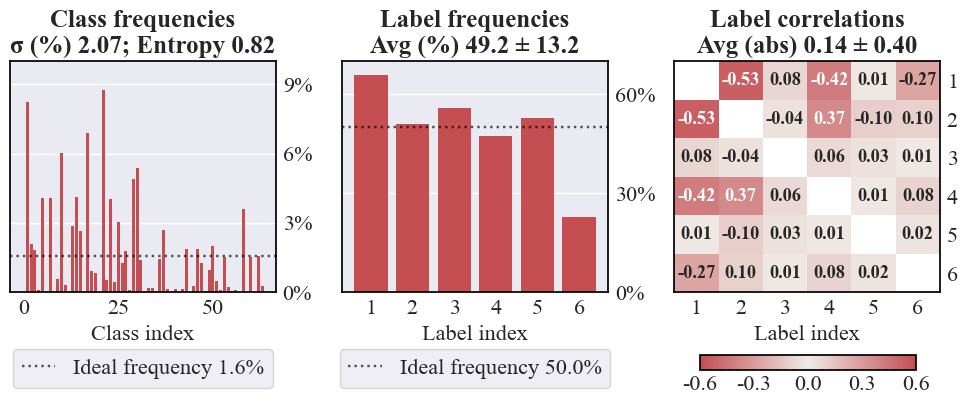

In [34]:
fig = summarise_dataset_lg(train_Y, train_Y_cat, 'No Resampling', main_col=RED, main_cmap=RCMAP)
fig.savefig(os.path.join(PLOT_DATA, 'data_distribution_nr_lg.pdf'), bbox_inches='tight')

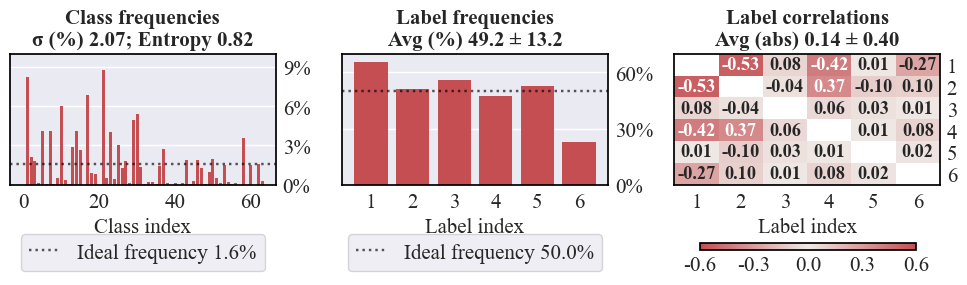

In [35]:
fig = summarise_dataset(train_Y, train_Y_cat, 'No Resampling', main_col=RED, main_cmap=RCMAP)
fig.savefig(os.path.join(PLOT_DATA, 'data_distribution_nr.pdf'), bbox_inches='tight')

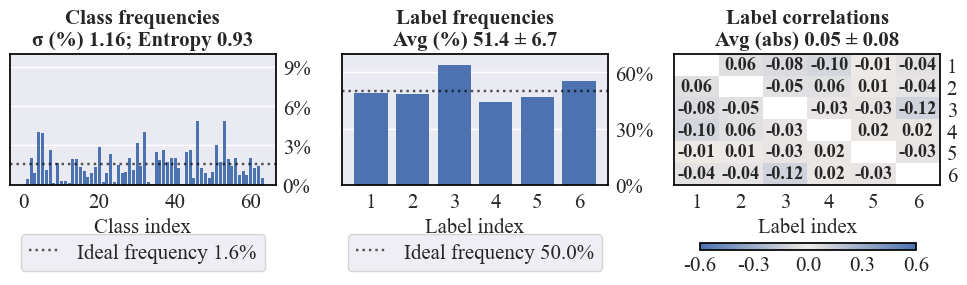

In [36]:
fig = summarise_dataset(train_Y_lb, train_Y_cat_lb, 'Label Resampled', main_col=BLUE, main_cmap=BCMAP)
fig.savefig(os.path.join(PLOT_DATA, 'data_distribution_lr.pdf'), bbox_inches='tight')

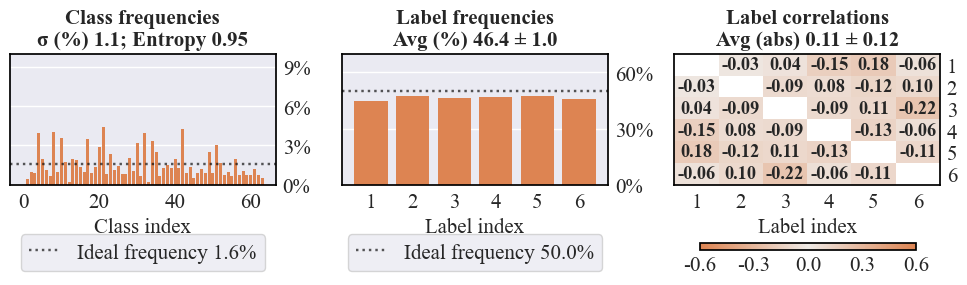

In [37]:
fig = summarise_dataset(train_Y_cb, train_Y_cat_cb, 'Class Resampled', main_col=ORANGE, main_cmap=OCMAP)
fig.savefig(os.path.join(PLOT_DATA, 'data_distribution_cr.pdf'), bbox_inches='tight')


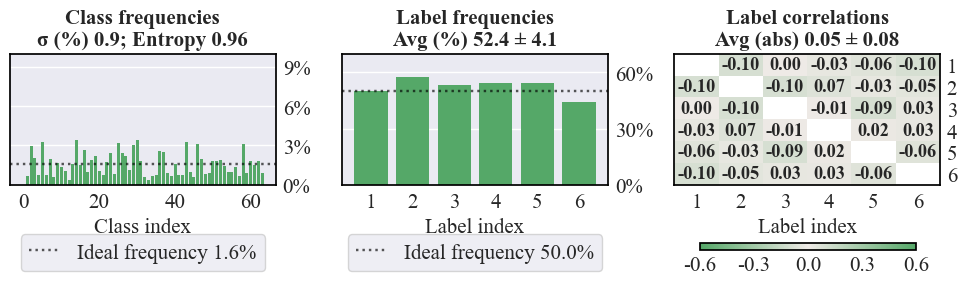

In [38]:
fig = summarise_dataset(train_Y_ab, train_Y_cat_ab, 'Adaptive Resampled', main_col=GREEN, main_cmap=GCMAP)
fig.savefig(os.path.join(PLOT_DATA, 'data_distribution_ar.pdf'), bbox_inches='tight')

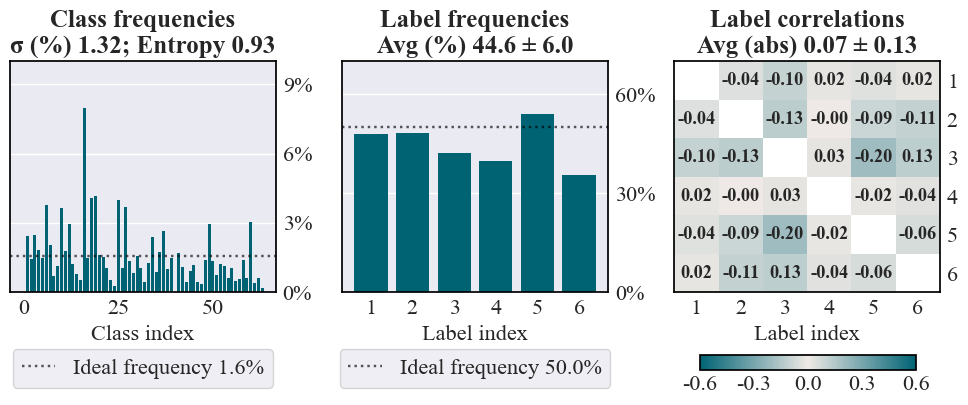

In [40]:
fig = summarise_dataset_lg(dsbi_Y, dsbi_Y_cat, 'DSBI Test', main_col=TPAL[4], main_cmap=CCMAP)
fig.savefig(os.path.join(PLOT_DATA, 'data_distribution_ood_lg.pdf'), bbox_inches='tight')

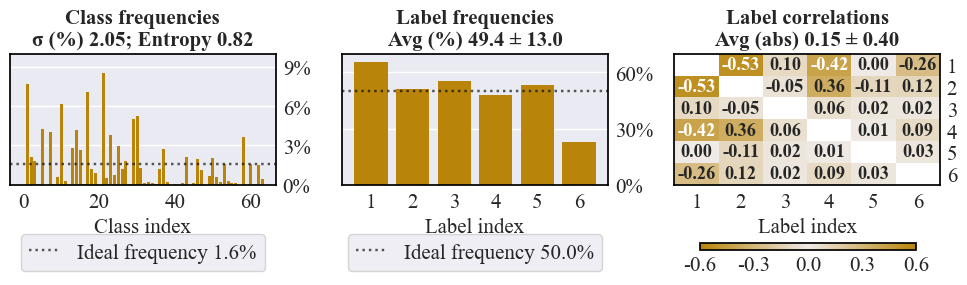

In [39]:
fig = summarise_dataset(test_Y, test_Y_cat, 'Test', main_col=TPAL[1], main_cmap=YCMAP)
# fig.savefig(os.path.join(PLOT_DATA, 'data_distribution_test.pdf'), bbox_inches='tight')

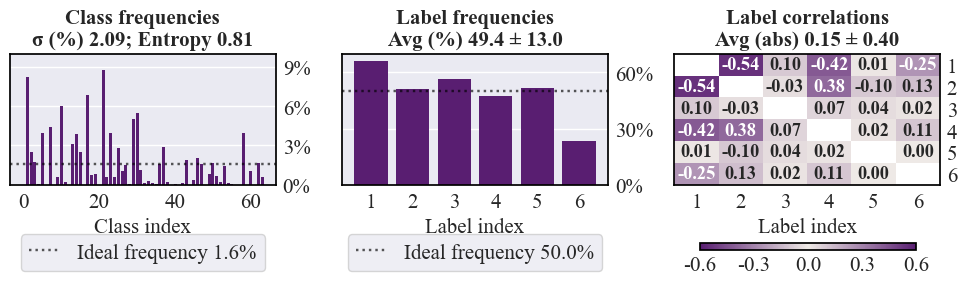

In [44]:
fig = summarise_dataset(val_Y, val_Y_cat, 'Validation', main_col=TPAL[0], main_cmap=PCMAP)
# fig.savefig(os.path.join(PLOT_DATA, 'data_distribution_val.pdf'), bbox_inches='tight')

In [51]:
with open(os.path.join('..', 'dicts', 'dataset_distributions.json'), 'w') as dfile:
    json.dump(dataset_distributions, dfile)

In [42]:
dataset_distributions['No Resampling']['Dot Frequencies']

array([0.65849539, 0.50929014, 0.55916959, 0.47403525, 0.52671546,
       0.22727995])

In [191]:
{k: v['Class Frequencies'].max()-v['Class Frequencies'].min() for k, v in dataset_distributions.items()}

{'No Resampling': 0.08744423751570012,
 'Label Resampled': 0.04900426396221559,
 'Class Resampled': 0.04441895446833939,
 'Adaptive Resampled': 0.03415451294255288,
 'Test': 0.0853861517976032,
 'DSBI Test': 0.07975540798211585}

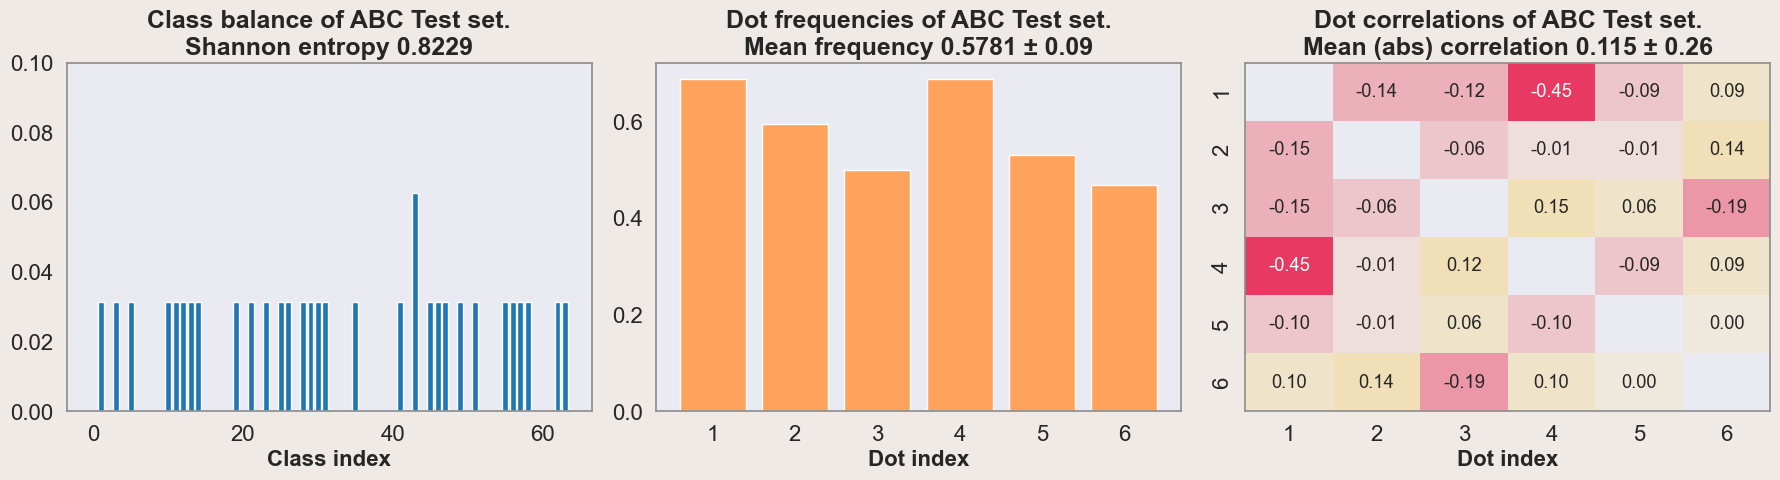

In [29]:
summarise_dataset(abc_Y, abc_Y_cat, 'ABC Test')

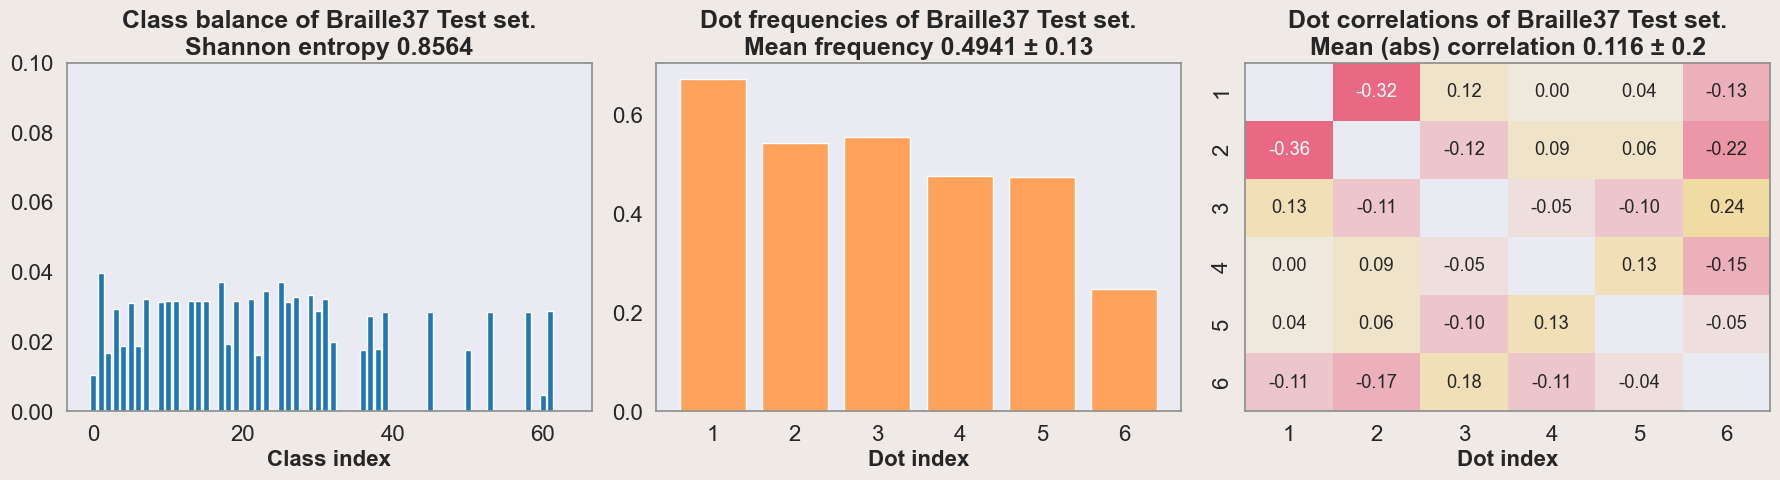

In [30]:
summarise_dataset(b37_Y, b37_Y_cat, 'Braille37 Test')

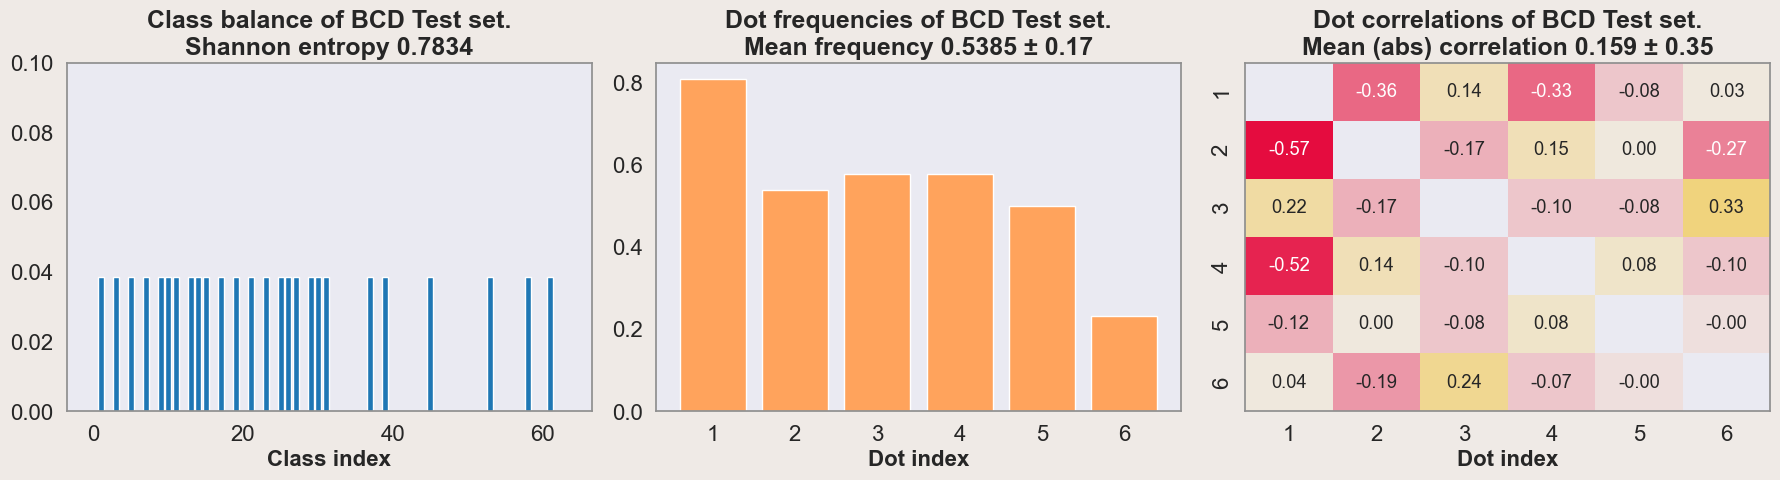

In [31]:
summarise_dataset(bcd_Y, bcd_Y_cat, 'BCD Test')

#### Comparing distributions

In [33]:
dataset_distributions.keys()

dict_keys(['No Resampling', 'Test', 'DSBI Test', 'ABC Test', 'Braille37 Test', 'BCD Test'])

In [40]:
def mean_abs_diff(arr1, arr2):
    return np.nanmean(np.abs(arr1 - arr2))

In [41]:
dataset_comparisons = pd.DataFrame(columns=['Class Frequencies', 'Dot Frequencies', 'Dot Correlations'])
train_dists = dataset_distributions['No Resampling']

for test1, dist1 in dataset_distributions.items():
    name = test1 if test1 != 'No Resampling' else 'Train'
    cf_diff = mean_abs_diff(dist1['Class Frequencies'], train_dists['Class Frequencies'])
    lf_diff = mean_abs_diff(dist1['Dot Frequencies'], train_dists['Dot Frequencies'])
    corr_diff = mean_abs_diff(dist1['Dot Correlations'][2], train_dists['Dot Correlations'][2])
    dataset_comparisons.loc[name] = [cf_diff, lf_diff, corr_diff]

In [42]:
dataset_comparisons

,Class Frequencies,Dot Frequencies,Dot Correlations
Train,0.000000,0.000000,0.000000
Test,0.000859,0.003992,0.007639
DSBI Test,0.016702,0.093552,0.184841
ABC Test,0.016093,0.105351,0.138401
Braille37 Test,0.011225,0.020819,0.166619
BCD Test,0.011554,0.054869,0.151422


In [44]:
approx_augmentation_level = {
    'Train': 0,
    'Test': 0,
    'DSBI Test': 0,
    'Braille37 Test': (26*35+26*14+356+1092) / (145+36+1404+572+396+1092),
    'ABC Test': 8 / 9.,
    'BCD Test': 1,
}
approx_augmentation_level

{'Train': 0,
 'Test': 0,
 'DSBI Test': 0,
 'Braille37 Test': 0.7467764060356653,
 'ABC Test': 0.8888888888888888,
 'BCD Test': 1}

In [55]:
resampling_augmentation_levels = {
    'LB Resampled': (53700+42172+8953) / (N-30329+53700+42172+8953),
    'CB Resampled': (54115+30264+22294) / (N-30349+54115+30264+22294),
    'AB Resampled': (11900+11900+11900) / (N-29750+11900+11900+11900),
}
resampling_augmentation_levels

{'LB Resampled': 0.7291514506514194,
 'CB Resampled': 0.7326895206434464,
 'AB Resampled': 0.47462674661313264}

### 2x2 Plot of Key Dataset Characteristics

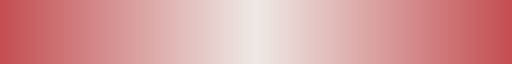

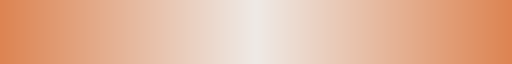

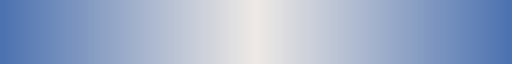

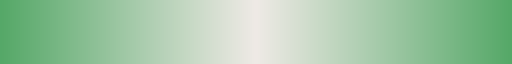

In [162]:
RCMAP = sns.blend_palette([
    RED,
    LIGHT,
    RED
], as_cmap=True)
OCMAP = sns.blend_palette([
    ORANGE,
    LIGHT,
    ORANGE
], as_cmap=True)
BCMAP = sns.blend_palette([
    BLUE,
    LIGHT,
    BLUE
], as_cmap=True)
GCMAP = sns.blend_palette([
    GREEN,
    LIGHT,
    GREEN
], as_cmap=True)

display(RCMAP)
display(OCMAP)
display(BCMAP)
display(GCMAP)

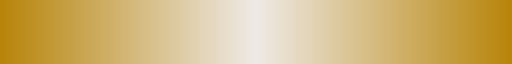

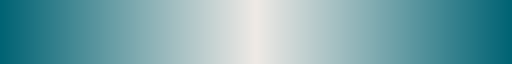

In [163]:

YCMAP = sns.blend_palette([
    TPAL[1],
    LIGHT,
    TPAL[1]
], as_cmap=True)
CCMAP = sns.blend_palette([
    TPAL[4],
    LIGHT,
    TPAL[4]
], as_cmap=True)

display(YCMAP)
display(CCMAP)

In [156]:
def visualise_datasets(data_X, data_Y, data_Y_cat, name, seed=111111,
                       main_col=BLUE, main_cmap=BCMAP):
    # sns.set_theme(sns_style2)
    sns.set_theme(style=sns_style2)
    cf = class_frequency(data_Y_cat)
    lf = class_frequency(data_Y)

    _, _, corr = label_correlations(data_Y)
    
    ticks = np.arange(len(lf))
    labels = ticks + 1

    # plt.rcParams['axes.edgecolor'] = GREY
    fig, axes = plt.subplot_mosaic([
                                ['b', 'b', 'b', 'b', 'c', 'c', 'c', 'c'],
                                ['b', 'b', 'b', 'b', 'c', 'c', 'c', 'c'],
                                ['a0', 'a2', 'a4', 'a6', 'd', 'd', 'd', 'd'],
                                ['a1', 'a3', 'a5', 'a7', 'd', 'd', 'd', 'd']],
                              layout='compressed',
                            #   gridspec_kw={
                            #       'hspace': 0.5
                            #     },
                              figsize=(9, 6),
                              facecolor=WHITE
                              )
    # plt.suptitle(f'Characteristics of the {name} dataset', fontsize=LBL_LARGE)
    
    np.random.seed(seed)
    S = 8
    subset = np.random.choice(np.arange(0, data_Y.shape[0]), S)
    for i in range(S):
        a = f'a{i}'
        sample = (data_X[subset[i]]).astype(np.float32)
        ax = axes[a]
        ax.axis("off")
        ax.imshow(sample)

    axes['b'].bar(x=range(len(cf)), height=cf, color=main_col, zorder=2)
    axes['b'].set_title(f'Class balance', fontsize=LBL_SIZE,
        # fontweight='bold'
    )
    axes['b'].tick_params('both', labelsize=TICK_SIZE)
    axes['b'].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
    bxl = axes['b'].get_xlim()
    axes['b'].set_xlim(bxl)
    ref = 1 / len(cf)
    sns.lineplot(x=list(bxl), y=[ref]*2, color=BLACK, linestyle=':', alpha=0.65,
                 ax=axes['b'], zorder=3, linewidth=1.75, label=f"Ideal class frequency {ref*100:.1f}%")

    axes['b'].legend(loc='lower center', bbox_to_anchor=(0.5, 1.2),
                     handlelength=2.0, fontsize=TINY+2)


    axes['c'].bar(x=labels, height=lf, color=main_col, zorder=2)
    cxl = axes['c'].get_xlim()
    axes['c'].set_xlim(cxl)
    sns.lineplot(x=list(cxl), y=[0.5, 0.5], color=BLACK, linestyle=':', alpha=0.65,
                 ax=axes['c'], zorder=3, linewidth=1.75, label="Ideal label frequency 50%")
    axes['c'].set_title(f'Dot frequencies', fontsize=LBL_SIZE,
        # fontweight='bold'
    )
    axes['c'].tick_params('both', labelsize=TICK_SIZE)
    axes['c'].set_xticks(labels, labels)
    axes['c'].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
    axes['c'].tick_params(axis='y', which='both', labelleft=False, left=False, right=False, labelright=True)
    axes['c'].legend(loc='lower center', bbox_to_anchor=(0.5, 1.2),
                     handlelength=2.0, fontsize=TINY+2)

    res = sns.heatmap(corr, annot=True, fmt='.2f', annot_kws={
            'fontweight': 'bold'
        }, vmin=-0.6, vmax=0.6, cmap=main_cmap, ax=axes['d'], 
        cbar_kws={
            'orientation': 'vertical', 'format': ticker.FormatStrFormatter('%.1f'),
            'location': 'left', 'fraction': 0.15, 'shrink': 0.9, 'aspect': 12,
        }
    )
    cbar_ax = axes['d'].collections[0].colorbar.ax
    cbar_ax.tick_params(axis='y', length=0, labelsize=TINY)
    axes['d'].set_title(f'Dot correlations', fontsize=LBL_SIZE,
        # fontweight='bold'
    )
    axes['d'].tick_params('both', labelsize=TICK_SIZE)
    axes['d'].set_xticks(ticks+0.5, labels)
    axes['d'].set_yticks(ticks+0.5, labels)
    axes['d'].tick_params(axis='y', which='both', labelleft=False, left=False, right=False, labelright=True)
    axes['d'].set_facecolor(WHITE)
    
    for _, spine in res.spines.items(): 
        spine.set_visible(True)
        
    # plt.subplots_adjust(hspace=0.25)
    

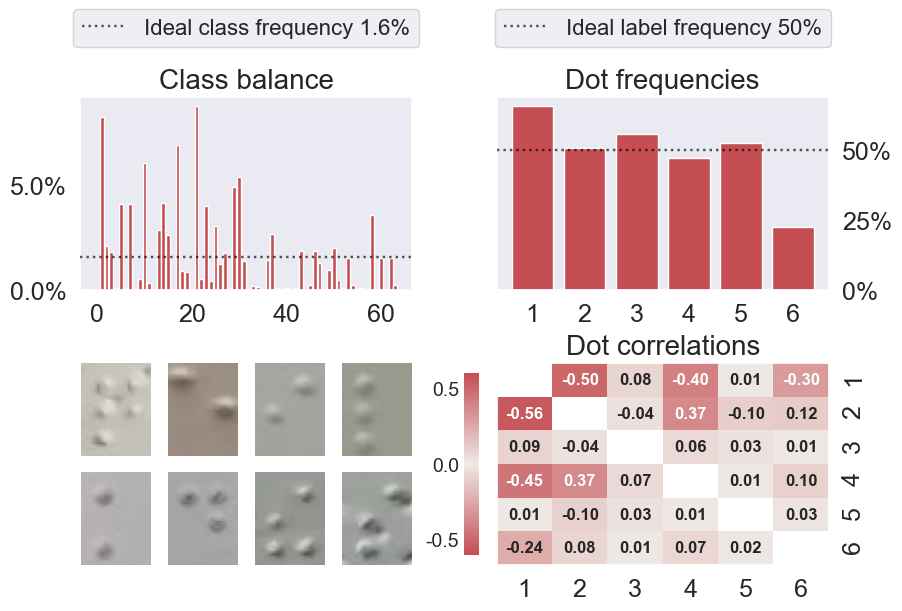

In [157]:
visualise_datasets(train_X, train_Y, train_Y_cat, 'Angelina', main_col=RED, main_cmap=RCMAP)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
def label_cooccurrence(data, b1, b2):
    cm = confusion_matrix(data[:,b1], data[:,b2])
    T = np.sum(cm)
    S = cm[0,0] + cm[1,1]
    O = T - S

    print(f"Same: {S} out of {T}; {round(100 * S / T, 2)}%")
    print(f"Opposite: {O} out of {T}; {round(100 * O / T, 2)}%")

In [ ]:
label_cooccurrence(train_Y, 0, 1)

Same: 17380 out of 69267; 25.09%
Opposite: 51887 out of 69267; 74.91%


In [ ]:
label_cooccurrence(train_Y, 3, 1)

Same: 47449 out of 69267; 68.5%
Opposite: 21818 out of 69267; 31.5%


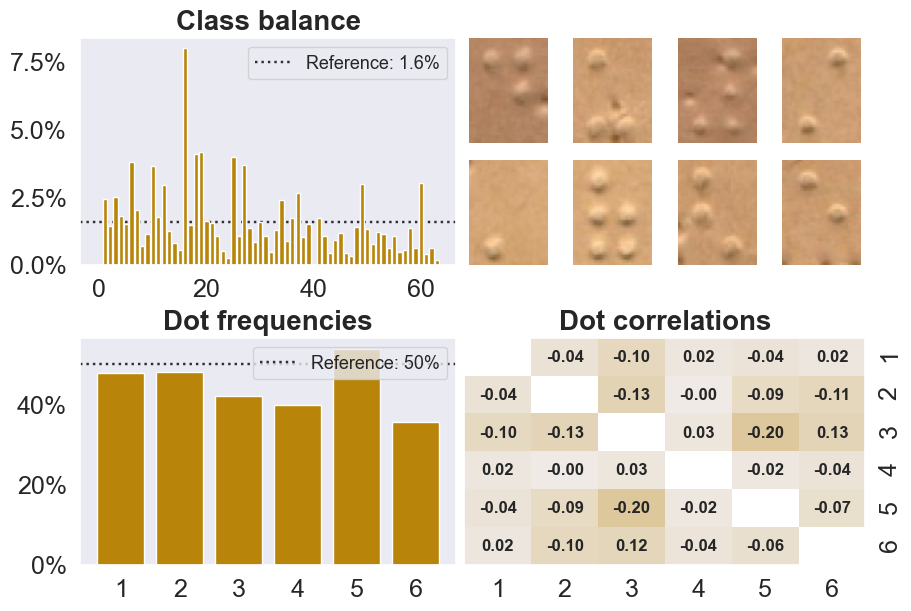

In [85]:
visualise_datasets(dsbi_X, dsbi_Y, dsbi_Y_cat, 'DSBI', main_col=TPAL[1], main_cmap=YCMAP)

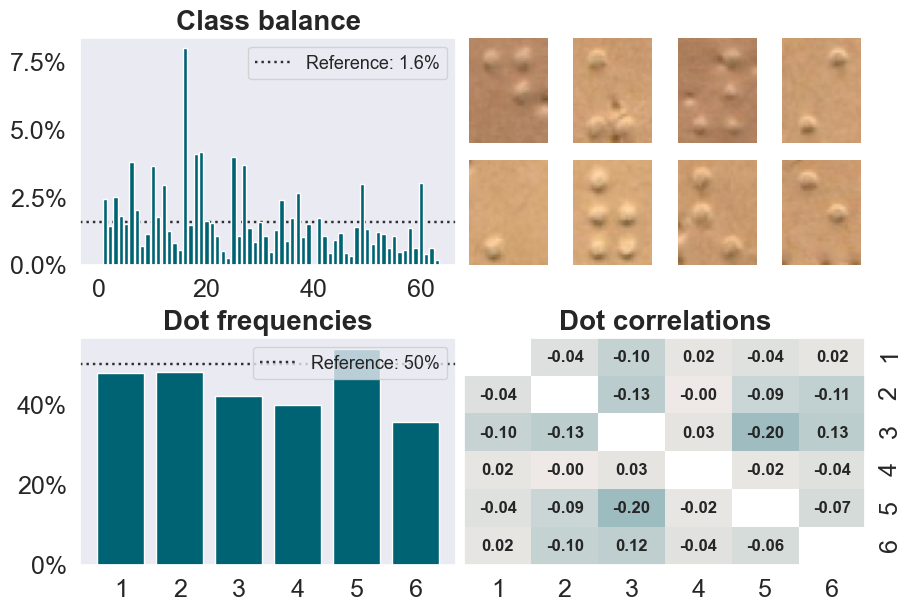

In [86]:
visualise_datasets(dsbi_X, dsbi_Y, dsbi_Y_cat, 'DSBI', main_col=TPAL[4], main_cmap=CCMAP)

In [ ]:
label_cooccurrence(ood_Y, 4, 2)

Same: 18014 out of 45627; 39.48%
Opposite: 27613 out of 45627; 60.52%


In [ ]:
label_cooccurrence(ood_Y, 5, 2)

Same: 26549 out of 45627; 58.19%
Opposite: 19078 out of 45627; 41.81%


### Most and Least Frequent classes per Language Set

In [218]:
class_frequencies = pd.DataFrame()

class_frequencies['Angelina'] = class_frequency(train_Y_cat) * 100
class_frequencies['DSBI'] = class_frequency(dsbi_Y_cat) * 100
class_frequencies['Binary Label'] = np.apply_along_axis(lambda x: ''.join(x.astype(str)), axis=1, arr=num_to_bin(class_frequencies.index.to_numpy()))


In [249]:
# Do not appear in Angelina
class_frequencies.sort_values('Angelina').head(30)

,Angelina,DSBI,Binary Label
0,0.000000,0.000000,000000
41,0.000000,1.707322,100101
59,0.002887,0.607097,110111
57,0.002887,0.547921,100111
61,0.005775,0.403270,101111
20,0.008662,1.626230,001010
16,0.010106,7.975541,000010
39,0.012993,1.494729,111001
12,0.015881,2.947816,001100
44,0.027430,0.922699,001101


In [255]:
class_frequencies.sort_values('Angelina').loc[[6,12,16]].DSBI.sum()

14.699629605277575

In [215]:
train_Y_cat[:, [41, 59, 57]].sum(axis=0)

array([0, 2, 2])

In [23]:
# Do not appear in DSBI
class_frequencies.sort_values('DSBI').head(11)

,Angelina,DSBI,Binary Label
0,0.000000,0.000000,000000
40,0.116939,0.004383,000101
63,0.256977,0.184102,111111
24,0.435994,0.258619,000110
47,1.279108,0.339711,111101
61,0.005775,0.403270,101111
43,1.876796,0.431762,110101
46,1.850809,0.449295,011101
32,0.067853,0.451487,000001
56,0.102502,0.473404,000111


In [216]:
dsbi_Y_cat[:, [40, 63, 24]].sum(axis=0)

array([  2,  84, 118])

In [24]:
# Top 5 in Angelina
class_frequencies.sort_values('Angelina', ascending=False).head(10)

,Angelina,DSBI,Binary Label
21,8.744424,1.538563,101010
1,8.217477,2.413045,100000
17,6.887840,1.477196,100010
10,6.025958,3.644772,010100
30,5.367635,1.571438,011110
29,4.909986,0.832840,101110
14,4.134725,0.784623,011100
7,4.087083,2.031692,111000
5,4.072646,1.483771,101000
23,4.016343,0.523813,111010


In [25]:
# Top 5 in DSBI
class_frequencies.sort_values('DSBI', ascending=False).head(10)

,Angelina,DSBI,Binary Label
16,0.010106,7.975541,000010
19,0.847445,4.157626,110010
18,0.921074,4.074342,010010
25,3.037521,3.991058,100110
6,0.043311,3.776273,011000
27,1.785843,3.686414,110110
10,6.025958,3.644772,010100
60,1.508655,3.026717,001111
49,0.971603,2.969733,100011
12,0.015881,2.947816,001100


In [26]:
# Top 5 in Angelina
class_frequencies['Angelina'].sort_values(ascending=False).head(9).sum()

52.447774553539205

In [27]:
# Top 5 in DSBI
class_frequencies['DSBI'].sort_values(ascending=False).head(14).sum()

50.17204725272317

In [28]:
class_frequencies['Angelina'].sort_values(ascending=False).head(31).sum()

95.3397721858894

In [29]:
class_frequencies['DSBI'].sort_values(ascending=False).head(51).sum()

95.38869529006948

In [30]:
sns.set_style('darkgrid')

In [31]:
import ast

In [32]:
print('\u280a')

⠊


In [33]:

hexes = [0,1,2,3,4,5,6,7,8,9,'a','b','c','d','e','f']
unicodes = [
    f'"\\u28{a}{b}"' for b in hexes for a in hexes
]
braille_codes = [
    ast.literal_eval(uc) for uc in unicodes
]
[print(f'{uc} - {bc}(⣿)\n----------') for uc, bc in zip(unicodes, braille_codes)];

"\u2800" - ⠀(⣿)
----------
"\u2810" - ⠐(⣿)
----------
"\u2820" - ⠠(⣿)
----------
"\u2830" - ⠰(⣿)
----------
"\u2840" - ⡀(⣿)
----------
"\u2850" - ⡐(⣿)
----------
"\u2860" - ⡠(⣿)
----------
"\u2870" - ⡰(⣿)
----------
"\u2880" - ⢀(⣿)
----------
"\u2890" - ⢐(⣿)
----------
"\u28a0" - ⢠(⣿)
----------
"\u28b0" - ⢰(⣿)
----------
"\u28c0" - ⣀(⣿)
----------
"\u28d0" - ⣐(⣿)
----------
"\u28e0" - ⣠(⣿)
----------
"\u28f0" - ⣰(⣿)
----------
"\u2801" - ⠁(⣿)
----------
"\u2811" - ⠑(⣿)
----------
"\u2821" - ⠡(⣿)
----------
"\u2831" - ⠱(⣿)
----------
"\u2841" - ⡁(⣿)
----------
"\u2851" - ⡑(⣿)
----------
"\u2861" - ⡡(⣿)
----------
"\u2871" - ⡱(⣿)
----------
"\u2881" - ⢁(⣿)
----------
"\u2891" - ⢑(⣿)
----------
"\u28a1" - ⢡(⣿)
----------
"\u28b1" - ⢱(⣿)
----------
"\u28c1" - ⣁(⣿)
----------
"\u28d1" - ⣑(⣿)
----------
"\u28e1" - ⣡(⣿)
----------
"\u28f1" - ⣱(⣿)
----------
"\u2802" - ⠂(⣿)
----------
"\u2812" - ⠒(⣿)
----------
"\u2822" - ⠢(⣿)
----------
"\u2832" - ⠲(⣿)
----------
"\u2842" - ⡂(⣿)
----------
"

In [34]:
nr_top = [
    '⠕', '⠁', '⠑', '⠊', '⠞', '⠝', '⠎', '⠇', '⠅', '⠗'
]
ood_top = [
    '⠐', '⠓', '⠒', '⠙', '⠆', '⠛', '⠊', '⠼', '⠱', '⠌'
]

nr_bot = [
    '⠻', '⠹', '⠽', '⠔', '⠐', '⠧', '⠌', '⠬', '⠆', '⠷'
]
ood_bot = [
    '⠨', '⠿', '⠘', '⠯', '⠽', '⠫', '⠮', '⠠', '⠸', '⠗'
]

excluded = [
    '⠀', '⠩'
]

In [35]:
print('\u28ff')

⣿


In [36]:

[print(f'{uc} - {bc}(⣿)\n----------') for uc, bc in zip(unicodes, braille_codes) if bc in excluded];

"\u2800" - ⠀(⣿)
----------
"\u2829" - ⠩(⣿)
----------


[21, 1, 17, 10, 30, 29, 14, 7, 5, 23]

In [224]:
nr_top = [
    '\u2815', '\u2801', '\u2811', '\u280a', '\u281e', '\u281d', '\u280e', '\u2807', '\u2805', '\u2817'
]
nr_top_dec = class_frequencies[class_frequencies.Angelina > 0.0].sort_values('Angelina', ascending=False).head(10).index.to_list()

ood_top = [
    '\u2810', '\u2813', '\u2812', '\u2819', '\u2806', '\u281b', '\u280a', '\u283c', '\u2831', '\u280c'
]
ood_top_dec = class_frequencies[class_frequencies.DSBI > 0.0].sort_values('DSBI', ascending=False).head(10).index.to_list()

nr_bot = [
    '\u283b', '\u2839', '\u283d', '\u2814', '\u2810', '\u2827', '\u280c', '\u282c', '\u2806', '\u2837'
]
nr_bot_dec = class_frequencies[class_frequencies.Angelina > 0.0].sort_values('Angelina', ascending=True).head(10).index.to_list()

ood_bot = [
    '\u2828', '\u283f', '\u2818', '\u282f', '\u283d', '\u282b', '\u282e', '\u2820', '\u2838', '\u2817'
]
ood_bot_dec = class_frequencies[class_frequencies.DSBI > 0.0].sort_values('DSBI', ascending=True).head(10).index.to_list()

excluded = [
    '\u2800', '\u2829'
]

In [38]:
from matplotlib import font_manager

In [140]:
font_path = os.path.join('..', 'dicts', 'UBraille.ttf')  
# font_path = os.path.join('..', 'dicts', 'braille_font3.ttf')  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = ["Times New Roman", prop.get_name()]
# plt.rcParams['font.'] = prop.get_name()


In [101]:
from matplotlib.patches import FancyBboxPatch

In [112]:
plt.setp(axes[0, 0].get_xticklabels())

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased: bool
  backgroundcolor: :mpltype:`color`
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: :mpltype:`color`
  figure: `~matplotlib.figure.Figure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'ext

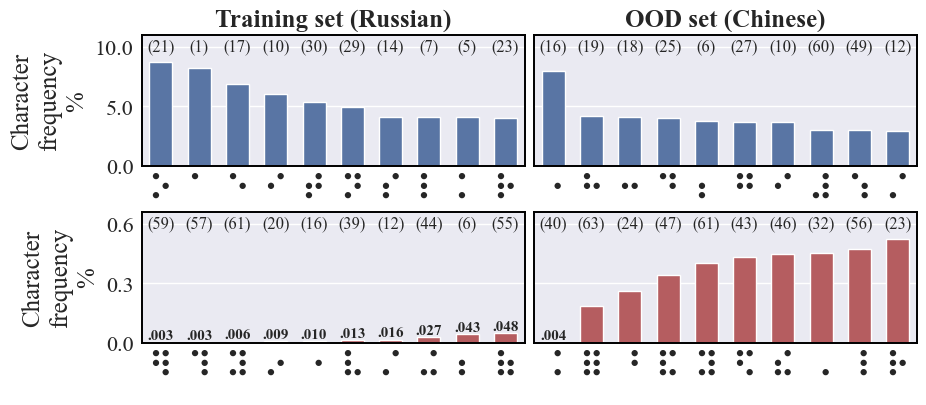

In [247]:
num = 10
plt.rcParams['axes.edgecolor'] = BLACK
# plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams['font.family'] = 'sans-serif'
fig, axes = plt.subplots(2,2, figsize=(10,4), sharey='row', facecolor=WHITE)
sns.barplot(x=range(num), y=class_frequencies['Angelina'].sort_values(ascending=False).head(num), width=0.6, ax=axes[0, 0], color=BLUE)
axes[0, 0].set_ylim(0, 11)
axes[0, 0].set_yticks([0, 5, 10], ['0.0', '5.0', '10.0'])
axes[0, 0].set_ylabel('Character\nfrequency\n%', fontsize=LBL_SIZE)
axes[0, 0].set_title('Training set (Russian)', fontsize=LBL_SIZE, fontweight='bold')
axes[0, 0].tick_params(axis='y', labelsize=TICK_SIZE, pad=0)
axes[0, 0].set_xticks([r-0.15 for r in range(10)], nr_top)

ax2 = axes[0,0].twiny()
ax2.grid(axis='x', visible=False)
ax2.set_xticks([r for r in range(10)], [f"({d})" for d in nr_top_dec])
ax2.set_xlim(axes[0,0].get_xlim())
ax2.tick_params(axis='x', labelsize=TICK_SIZE-4, which='both', pad=-20, bottom=False, top=False)
axes[0, 0].tick_params(axis='x', labelsize=TICK_SIZE*2, bottom=False, top=False)

sns.barplot(x=range(num), y=class_frequencies['DSBI'].sort_values(ascending=False).head(num), width=0.6, ax=axes[0, 1], color=BLUE)
axes[0, 1].set_title('OOD set (Chinese)', fontsize=LBL_SIZE, fontweight='bold')
axes[0, 1].set_xticks([r-0.15 for r in range(10)], ood_top)

ax2 = axes[0,1].twiny()
ax2.grid(axis='x', visible=False)
ax2.set_xticks([r for r in range(10)], [f"({d})" for d in ood_top_dec])
ax2.set_xlim(axes[0,1].get_xlim())
ax2.tick_params(axis='x', labelsize=TICK_SIZE-4, which='both', pad=-20, bottom=False, top=False)
axes[0, 1].tick_params(axis='x', labelsize=TICK_SIZE*2, bottom=False, top=False)

ax10_ys = class_frequencies[class_frequencies['Angelina'] > 0]['Angelina'].sort_values(ascending=True).head(num)
sns.barplot(x=range(num), y=ax10_ys, width=0.6, ax=axes[1, 0], color=RED)
axes[1, 0].set_ylim(0, 0.66)
axes[1, 0].set_yticks([0, 0.3, 0.6])
axes[1, 0].set_ylabel('Character\nfrequency\n%', fontsize=LBL_SIZE)
axes[1, 0].tick_params(axis='y', labelsize=TICK_SIZE, pad=0)
axes[1, 0].set_xticks([r-0.15 for r in range(10)], nr_bot)
for x, y in enumerate(ax10_ys):
    axes[1, 0].text(x, y, f"{y:.3f}".lstrip('0'), ha='center',
     va='bottom', fontsize=TICK_SIZE-5, fontweight='bold')

ax2 = axes[1,0].twiny()
ax2.grid(axis='x', visible=False)
ax2.set_xticks([r for r in range(10)], [f"({d})" for d in nr_bot_dec])
ax2.set_xlim(axes[1,0].get_xlim())
ax2.tick_params(axis='x', labelsize=TICK_SIZE-4, which='both', pad=-20, bottom=False, top=False)
axes[1, 0].tick_params(axis='x', labelsize=TICK_SIZE*2, bottom=False, top=False)

ax11_ys = class_frequencies[class_frequencies['DSBI'] > 0]['DSBI'].sort_values(ascending=True).head(num)
sns.barplot(x=range(num), y=ax11_ys, width=0.6, ax=axes[1, 1], color=RED)
axes[1, 1].set_xticks([r-0.15 for r in range(10)], ood_bot)
axes[1, 1].text(0, ax11_ys.iloc[0], f"{ax11_ys.iloc[0]:.3f}".lstrip('0'), ha='center',
    va='bottom', fontsize=TICK_SIZE-5, fontweight='bold')

ax2 = axes[1,1].twiny()
ax2.grid(axis='x', visible=False)
ax2.set_xticks([r for r in range(10)], [f"({d})" for d in ood_bot_dec])
ax2.set_xlim(axes[1,1].get_xlim())
ax2.tick_params(axis='x', labelsize=TICK_SIZE-4, which='both', pad=-20, bottom=False, top=False)
axes[1, 1].tick_params(axis='x', labelsize=TICK_SIZE*2, bottom=False, top=False)

plt.subplots_adjust(hspace=0.35,wspace=0.025)
plt.savefig(os.path.join(PLOT_DATA, "extreme_character_frequencies.pdf"), bbox_inches='tight')

In [246]:
ax11_ys

40    0.004383
63    0.184102
24    0.258619
47    0.339711
61    0.403270
43    0.431762
46    0.449295
32    0.451487
56    0.473404
23    0.523813
Name: DSBI, dtype: float64

In [ ]:
class_frequencies[class_frequencies['Angelina'] > 0]['Angelina'].sort_values(ascending=True).head(num)

59    0.002887
57    0.002887
61    0.005775
20    0.008662
16    0.010106
39    0.012993
12    0.015881
44    0.027430
6     0.043311
55    0.047642
Name: Angelina, dtype: float64

In [ ]:
class_frequencies[class_frequencies['DSBI'] > 0]['DSBI'].sort_values(ascending=True).head(num)

40    0.004383
63    0.184102
24    0.258619
47    0.339711
61    0.403270
43    0.431762
46    0.449295
32    0.451487
56    0.473404
23    0.523813
Name: DSBI, dtype: float64

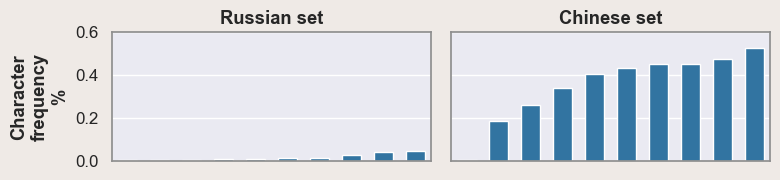

In [ ]:
num = 10
plt.rcParams['axes.edgecolor'] = GREY
fig, axes = plt.subplots(1,2, figsize=(8,2), sharey=True, facecolor=LIGHT)
sns.barplot(x=range(num), y=class_frequencies[class_frequencies['Angelina'] > 0]['Angelina'].sort_values(ascending=True).head(num), width=0.6, ax=axes[0], color=CPAL[0])
axes[0].set_xticks([])
axes[0].set_ylim(0, 0.6)
axes[0].set_ylabel('Character\nfrequency\n%', fontweight='bold')
axes[0].set_title('Russian set', fontweight='bold')

sns.barplot(x=range(num), y=class_frequencies[class_frequencies['DSBI'] > 0]['DSBI'].sort_values(ascending=True).head(num), width=0.6, ax=axes[1], color=CPAL[0])
axes[1].set_xticks([])
axes[1].set_title('Chinese set', fontweight='bold')

plt.tight_layout()